## PTSA final project

### Deal with dataset

In [ ]:
!pip install --upgrade -q -r ptsa_req.txt
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os
from datetime import datetime
import seaborn as sns
# from darts.models.forecasting import arima
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
from scipy import optimize
from math import sqrt
import joblib
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')
from warnings import catch_warnings

palette = sns.color_palette("mako_r", 6)

### utils

In [2]:
## search for the best model
# P <= 3, Q <= 1; p <= 3, q <= 27 -> impossible to solve for such a range. so truncate.
# Note large q won't work. Computationally expensive.

# modified utils from the following sources
# https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/
# https://www.kaggle.com/code/leandrovrabelo/climate-change-forecast-sarima-model/notebook

order_aic = [] # store AIC per model here. Complementary to CV
## currently not in use

# forecast function
def sarima_forecast(history, config, aic = True):
    """
    order = (p,d,q)
    sorder = (P,D,Q,s)
    """
    global order_aic
    order, sorder = config[:3], config[3:]
    if len(sorder):
        # define model
        model = sarimax.SARIMAX(history, order=order,
                              seasonal_order= sorder,
                              trend=None, enforce_stationarity=False,
                              enforce_invertibility=False)
    else:
        model = sarimax.SARIMAX(history, order=order,
                              seasonal_order= (0,0,0,0),
                              trend=None, enforce_stationarity=False,
                              enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False) # do not print convergence message
    # if aic:
    #   order_aic = order_aic + [(config, model_fit.aic)]
    #   print(f'Model {config}: {model_fit.aic}')
    # make one step forecast
    yhat = model_fit.predict(start = len(history), end = len(history))
    return yhat[-1]


# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def walk_forward_validation(train, val, col, n_val, cfg):
        predictions = np.zeros(len(val))
        # seed history with training dataset
        history = list(train[col])
        val = list(val[col])
        # step over each time-step in the test set
        for i in tqdm(range(len(val))):
        # fit model and make forecast for history
            yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
            predictions[i] = yhat
        # add actual observation to history for the next loop
            history.append(val[i])
        # estimate prediction error
        error = measure_rmse(val, list(predictions))
        return error, predictions


# score a model, return None on failure
def score_model(train, val, col, n_val, cfg, debug=False, save = False, label = ''):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result, preds = walk_forward_validation(train, val, col, n_val, cfg)
    else:
    #   try:
    # # never show warnings when grid searching, too noisy
    #       with catch_warnings():
    #         warnings.filterwarnings("ignore")
        result, preds = walk_forward_validation(train, val, col, n_val, cfg)
      # except:
      #     error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.4f' % (key, result))
    if save:
        np.save(f'{os.getcwd()}/arma_{key}_predictions{label}.npy', preds)
    return (key, result)


# we need to set to sarimax gridsearch
def grid_search(train, val, col, n_val, cfg_list, parallel=True):
    global order_aic
    scores = None
    if parallel:
    # execute configs in parallel
        executor = Parallel(n_jobs=-1, backend='multiprocessing')
        tasks = (delayed(score_model)(train, val, col, n_val, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(train, val, col, n_val, cfg) for cfg in cfg_list]
        # remove empty results
        scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda x: x[1])
    return scores



In [3]:
## Fourier Transform from lab_10
def calculate_fourier_series(dt: float, signal: np.ndarray):
    """Calculate the Fourier series coefficients using the Fourier transform.

    Args:
        dt: Interval between samples.
        signal: Real signal at each point in time.

    Returns:
        Frequencies, A_n, and B_n coefficients for the fourier series
        representaiton.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not
        complex. You may want to take advantage of the norm keyword.
    """
    # Placeholders.
    a_n = None
    b_n = None

    # TODO: Calculate the frequencies of each A_n and B_n. Remember that the
    # maximum frequency you can measure (and the maximum value numpy.fft will return
    # for real-valued signals) will be the Nyquist frequency.
    frequencies = np.abs(np.fft.fftfreq(n = len(signal), d = dt)[:len(signal)//2 + 1])

    # TODO: Calculate the fourier series coefficients. Compare the equations from
    # the notes, and read the numpy.fft documentation carefully.
    fourier_transform = np.fft.fft(signal, n = len(signal), norm = 'forward')[:len(signal)//2 + 1] # \tilde x_n = c_n
    a_n = 2*fourier_transform.real
    b_n = -2*fourier_transform.imag

    return frequencies, a_n, b_n

def reconstructed_signal(frequency_mask: float, signal: np.ndarray):
    """Return the signal with a mask applied to the Fourier series.

    Args:
        frequency_mask: Terms in the Fourier series to mask.
        signal: Real signal at each point in time.

    Returns:
        Reconstructed signal after frequency mask has been applied.

    Notes:
        Take advantage of numpy.fft. Remember that the signal is real not
        complex.
    """
    # TODO: Calculate the fourier transform, apply the mask,
    # and reverse the transformation.
    fourier_transform = np.fft.fft(signal, n = len(signal), norm = 'forward')
    return np.fft.ifft(fourier_transform * mask, norm = 'forward').real

### Dataset

In [4]:
## Ithaca hourly data
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/hourly02-ithaca/hourly02-NY_Ithaca_13_E.csv'
Ithaca_hourly = pd.read_csv(url, index_col = 0)

## NYC central park data 1990-2023
url = 'https://raw.githubusercontent.com/TLI2958/PTSA_project/main/nyc_daily/3508670.csv'
nyc_daily = pd.read_csv(url, delimiter=',')
nyc_daily.isnull().sum() # no missing values for TMIN, TMAX per day


STATION        0
NAME           0
DATE           0
ACMH       12357
AWND        2389
PRCP           0
SNOW           0
SNWD         834
TAVG        9710
TMAX           0
TMIN           0
TSUN        9472
WT01        8472
WT02       12000
WT03       12064
WT04       12306
WT05       12046
WT06       12283
WT07       12267
WT08       10433
WT09       12338
WT11       12353
WT13       10034
WT14       12126
WT15       12344
WT16        9104
WT17       12298
WT18       11767
WT19       12179
WT21       12357
WT22       12273
dtype: int64

##### Ithaca hourly

In [5]:
Ithaca_hourly = Ithaca_hourly.loc[:, ['UTC_DATE','UTC_TIME','T_HR_AVG']]
Ithaca_hourly.dropna(inplace = True)
Ithaca_hourly = Ithaca_hourly.reset_index().drop('index', axis = 1)
Ithaca_hourly

UTC_DATE  UTC_TIME  T_HR_AVG
0       20041028         0       7.6
1       20041028       100       7.0
2       20041028       200       6.2
3       20041028       300       4.7
4       20041028       400       3.3
...          ...       ...       ...
165308  20231106         0       1.3
165309  20231106       100       0.0
165310  20231106       200      -0.4
165311  20231106       300      -1.3
165312  20231106       400      -1.6

[165313 rows x 3 columns]

In [6]:
Date = (pd.to_datetime(Ithaca_hourly.UTC_DATE, format='%Y%m%d', errors='coerce')
+ pd.to_timedelta(Ithaca_hourly.UTC_TIME//100, unit = 'hours'))

Ithaca_hourly['Time'] = Date
Ithaca_hourly.to_json('Ithaca_hourly.json')

##### Ithaca daily

In [7]:
Ithaca_daily = pd.DataFrame(Ithaca_hourly.groupby(Ithaca_hourly.Time.dt.date)['T_HR_AVG'].mean())
Ithaca_daily = Ithaca_daily.rename(columns = {'T_HR_AVG':'T_AVG'}).reset_index()
Ithaca_daily.Time = pd.to_datetime(Ithaca_daily.Time, format = '%Y-%m-%d', errors = 'coerce')
Ithaca_daily

Time      T_AVG
0    2004-10-28   5.520833
1    2004-10-29   7.712500
2    2004-10-30  13.116667
3    2004-10-31  14.233333
4    2004-11-01   7.687500
...         ...        ...
6904 2023-11-02   0.233333
6905 2023-11-03   5.375000
6906 2023-11-04   9.804167
6907 2023-11-05   7.037500
6908 2023-11-06  -0.400000

[6909 rows x 2 columns]

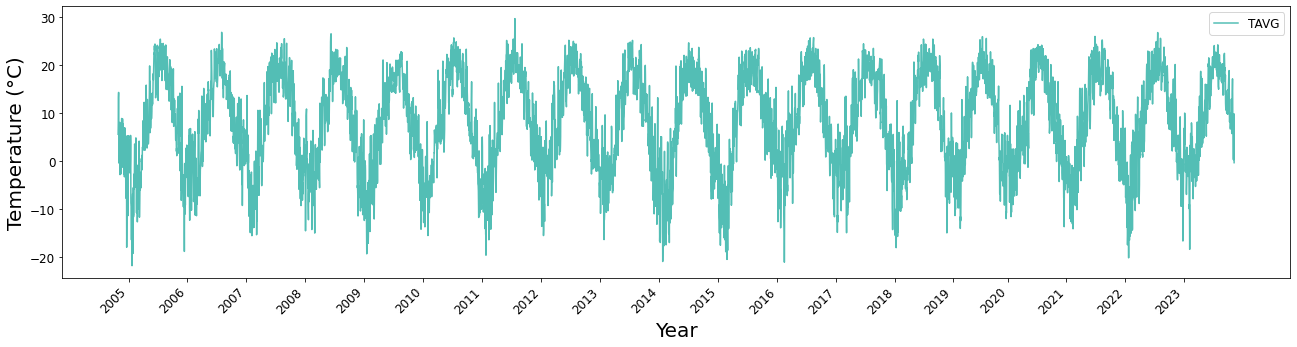

In [8]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = Ithaca_daily.shape[0]
# find beginning of each year, used for xtick labels
years_txt, years = np.unique(Ithaca_daily.Time.dt.year, return_index = True)

fig_overall, ax = plt.subplots(1,1, figsize = (22,5))
sns.lineplot(x = Ithaca_daily.index[:interval], y = Ithaca_daily['T_AVG'][:interval],
              color = palette[1], label = 'TAVG', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks(years[1:]) # 2004 collapsed...
ax.set_xticklabels(years_txt[1:], rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°C)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)
ax.legend(fontsize = 12)
plt.show()

##### NYC daily

In [9]:
Date = pd.to_datetime(nyc_daily.DATE, format='%Y-%m-%d', errors='coerce')
nyc_daily['year'], nyc_daily['month'], nyc_daily['day'] = Date.dt.year, Date.dt.month, Date.dt.day
nyc_daily

STATION                         NAME        DATE  ACMH  AWND  PRCP  \
0      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-01   NaN   NaN  0.24   
1      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-02   NaN   NaN  0.00   
2      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-03   NaN   NaN  0.00   
3      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-04   NaN   NaN  0.01   
4      USW00094728  NY CITY CENTRAL PARK, NY US  1990-01-05   NaN   NaN  0.00   
...            ...                          ...         ...   ...   ...   ...   
12353  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-28   NaN  4.92  0.00   
12354  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-29   NaN  6.93  0.47   
12355  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-30   NaN  4.47  0.59   
12356  USW00094728  NY CITY CENTRAL PARK, NY US  2023-10-31   NaN  3.80  0.00   
12357  USW00094728  NY CITY CENTRAL PARK, NY US  2023-11-01   NaN  6.71  0.01   

       SNOW  SNWD  TAVG  TMAX  ...  WT15  WT16  WT17  WT18  WT19  WT21  WT22  \
0       0.0   0.0   NaN    48  ...   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
1       0.0   0.0   NaN    44  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2       0.0   0.0   NaN    53  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3       0.0   0.0   NaN    51  ...   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
4       0.0   0.0   NaN    49  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...     ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
12353   0.0   0.0   NaN    80  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12354   0.0   0.0   NaN    63  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12355   0.0   0.0   NaN    60  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12356   0.0   0.0   NaN    51  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
12357   0.0   0.0   NaN    49  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

       year  month  day  
0      1990      1    1  
1      1990      1    2  
2      1990      1    3  
3      1990      1    4  
4      1990      1    5  
...     ...    ...  ...  
12353  2023     10   28  
12354  2023     10   29  
12355  2023     10   30  
12356  2023     10   31  
12357  2023     11    1  

[12358 rows x 34 columns]

In [10]:
nyc_daily_drop = nyc_daily.set_index('DATE').drop(['STATION','NAME', 'ACMH', 'TAVG', 'TSUN', 'AWND'],
                                                  axis =1) # drop since single station, tavg, tsun too many missing values
nyc_daily_drop.drop(nyc_daily_drop.columns[[i.startswith('WT') for \
                                            i in nyc_daily_drop.columns]], axis = 1, inplace = True)
nyc_daily = nyc_daily_drop.reset_index().drop('DATE', axis = 1)

### Plot

#### Plot functions (run before proceed)

In [11]:
## naive version
def plot_triple(df, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)

    ax2.stem(acf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated ACF')
    ax2.fill_between(np.arange(1, n_lags_ar + 1), acf_error_estimate, -acf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels([f'{int(i)}' for i in ax2.get_xticks()], rotation=45, ha='right')
    ax2.legend(fontsize=fontsize)

    ax3.stem(pacf_sm, linefmt=colors[0], markerfmt=colors[0], basefmt='k', label='Estimated PACF')
    ax3.fill_between(np.arange(1, n_lags_ma + 1), pacf_error_estimate, -pacf_error_estimate,
                     color=colors[1], label='Error in Estimate', alpha=0.2)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels([f'{int(i)}' for i in ax3.get_xticks()], rotation=45, ha='right')
    ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'output/{fig_name}.png', bbox_inches = 'tight')

In [12]:
## built-in plot_pcaf, plot_acf
def plot_triple_built_in(df, n_lags_ar, n_lags_ma, seasonality, lag_ma, col, fig_name = ''):
    acf_error_estimate = 2 * np.ones(n_lags_ar) / np.sqrt(len(df))
    pacf_error_estimate = 2 * np.ones(n_lags_ma) / np.sqrt(len(df))

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(22, 15), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)

    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax1.set_title('Data', fontsize=fontsize)
    sns.lineplot(x=df.index, y=df[col],
                 color=palette[1], label= col, alpha=0.9, ax=ax1)
    ax1.set_xticklabels([])
    ax1.set_xticks(years[1:])
    ax1.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax1.tick_params(axis='y', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax1.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax1.legend(fontsize=12)


    plot_acf(df[col], lags = np.arange(n_lags_ar)[::seasonality], ax = ax2)
    ax2.set_ylim([-1.2, 1.2])
    ax2.set_title('ACF Estimate', fontsize=fontsize)
    ax2.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax2.set_ylabel(r'$\rho(|h|)$', fontsize=fontsize)
    ax2.set_xticklabels([f'{int(i)}' for i in ax2.get_xticks()], rotation=45, ha='right')
    # ax2.legend(fontsize=fontsize)

    plot_pacf(df[col], lags = np.arange(n_lags_ma)[::lag_ma], ax = ax3)
    ax3.set_ylim([-1.0, 1.2])
    ax3.set_title('PACF Estimate', fontsize=fontsize)
    ax3.set_xlabel(r'$|h|$', fontsize=fontsize)
    ax3.set_ylabel(r'$\mathrm{PACF}(|h|)$', fontsize=fontsize)
    ax3.set_xticklabels([f'{int(i)}' for i in ax3.get_xticks()], rotation=45, ha='right')
    # ax3.legend(fontsize=fontsize)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'output/{fig_name}.png', bbox_inches = 'tight')

In [13]:
## forecast plot
def plot_forecast(X_train, X_val, preds, n_from_train_end, n_from_val_start, col, pred_col, save = False, label = ''):
    fig, ax = plt.subplots(1, 1, figsize=(22, 5), dpi=200)
    fontsize = 20
    labelsize = 12
    colors = ['#7fcdbb', '#2c7fb8']
    palette = sns.color_palette("mako_r", 6)
    
    X_train_trunc = X_train[-n_from_train_end:]
    X_val_trunc = X_val[:n_from_val_start]
    df = pd.concat([X_train_trunc, X_val_trunc], axis = 0)
    X_pred = pd.DataFrame(preds.squeeze(1)[:n_from_val_start], columns = [pred_col], index = X_val_trunc.index)
    X_pred['Time'] = X_val_trunc.Time
    years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

    ax.set_title('Forecast', fontsize=fontsize)
    sns.lineplot(x=X_train_trunc.index, y=X_train_trunc[col],
                 color=palette[1], lw = 1, label= f'Train_{col}', alpha=0.9, ax=ax)
    sns.lineplot(x=X_val_trunc.index, y=X_val_trunc[col],
                 color=palette[1], lw = 1, label= f'Val_{col}', alpha=0.9, ax=ax)
    sns.lineplot(x=X_pred.index, y=X_pred[pred_col],
                 color=palette[-1], lw = 1, label= f'Pred_{pred_col}', alpha=1, ax=ax)
    ax.set_xticklabels([])
    ax.set_xticks(years[1:])
    ax.set_xticklabels(years_txt[1:], rotation=45, ha='right')
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.set_ylabel('Temperature (°C)', fontsize=fontsize)
    ax.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
    ax.legend(fontsize=12)
    if save:
        fig.savefig(f'output/pred_{n_from_train_end}_{n_from_val_start}_{label}.png', bbox_inches = 'tight')

###### NYC daily

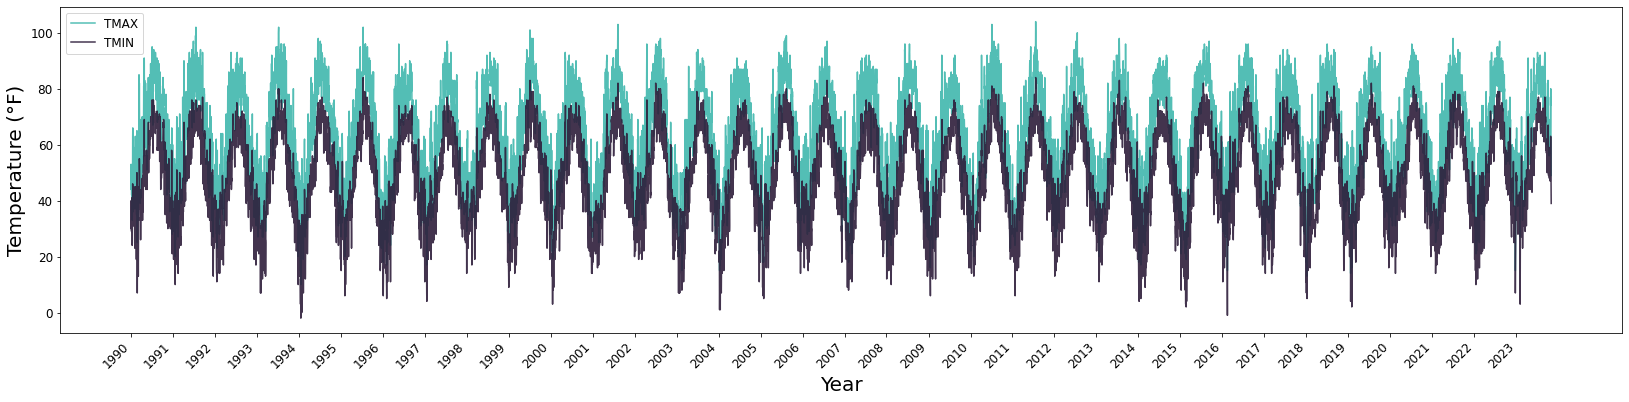

In [14]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = nyc_daily.shape[0]
years_txt, years = np.unique(nyc_daily.year, return_index = True)


fig_overall, ax = plt.subplots(1,1, figsize = (28,6))
sns.lineplot(x = nyc_daily.index[:interval], y = nyc_daily['TMAX'][:interval],
              color = palette[1], label = 'TMAX', alpha = 0.9)
sns.lineplot(x = nyc_daily.index[:interval], y = nyc_daily['TMIN'][:interval],
              color = palette[-1], label = 'TMIN', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xticks(years)
ax.set_xticklabels(years_txt, rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°F)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)

ax.legend(fontsize = 12)
plt.show()
# we see clear cyclic pattern

##### Ithaca hourly

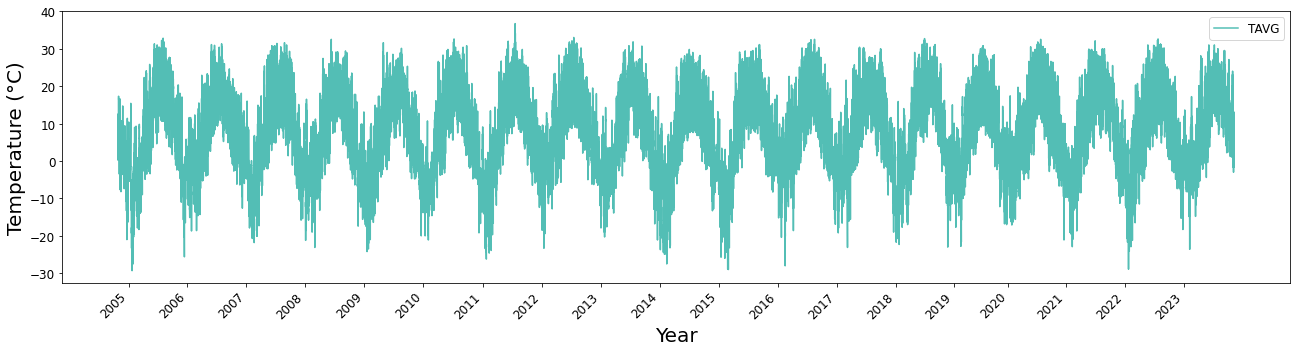

In [15]:
# violet = '#7b5aa6'
# gray = '#6d6d6d'
palette = sns.color_palette("mako_r", 6)

fontsize = 20
interval = Ithaca_hourly.shape[0]
# find beginning of each year, used for xtick labels
years_txt, years = np.unique(Ithaca_hourly.Time.dt.year, return_index = True)

fig_overall, ax = plt.subplots(1,1, figsize = (22,5))
sns.lineplot(x = Ithaca_hourly.index[:interval], y = Ithaca_hourly['T_HR_AVG'][:interval],
              color = palette[1], label = 'TAVG', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks(years[1:]) # 2004 collapsed...
ax.set_xticklabels(years_txt[1:], rotation = 45, ha= 'right')
ax.tick_params(axis = 'y', labelsize = 12)
ax.tick_params(axis = 'x', labelsize = 12)
ax.set_ylabel('Temperature (°C)', fontsize = fontsize)
ax.set_xlabel('Year', fontsize = fontsize, labelpad = 5.0)
ax.legend(fontsize = 12)
plt.show()
# we see clear cyclic pattern
# Hourly plot is more noisy. but I think both work.

### Initial Model

#### 0. train val split

In [17]:
### train val split: ~ 8:2
Ithaca_hourly_train = Ithaca_hourly[Ithaca_hourly.Time.dt.year < 2020]
Ithaca_hourly_val = Ithaca_hourly[Ithaca_hourly.Time.dt.year >=2020]
print(f'training set length = {Ithaca_hourly_train.shape[0]}\n val set length = {Ithaca_hourly_val.shape[0]}')

training set length = 131871
 val set length = 33442


#### 1. look at ACF, PACF, run KPSS, ADF test for stationarity

In [18]:
### Determine dependence order by plotting ACF
n_lags_ar = 365*24*10
n_lags_ma = 365
acf_sm = acf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ar)
pacf_sm = pacf(Ithaca_hourly_train.T_HR_AVG, nlags = n_lags_ma)

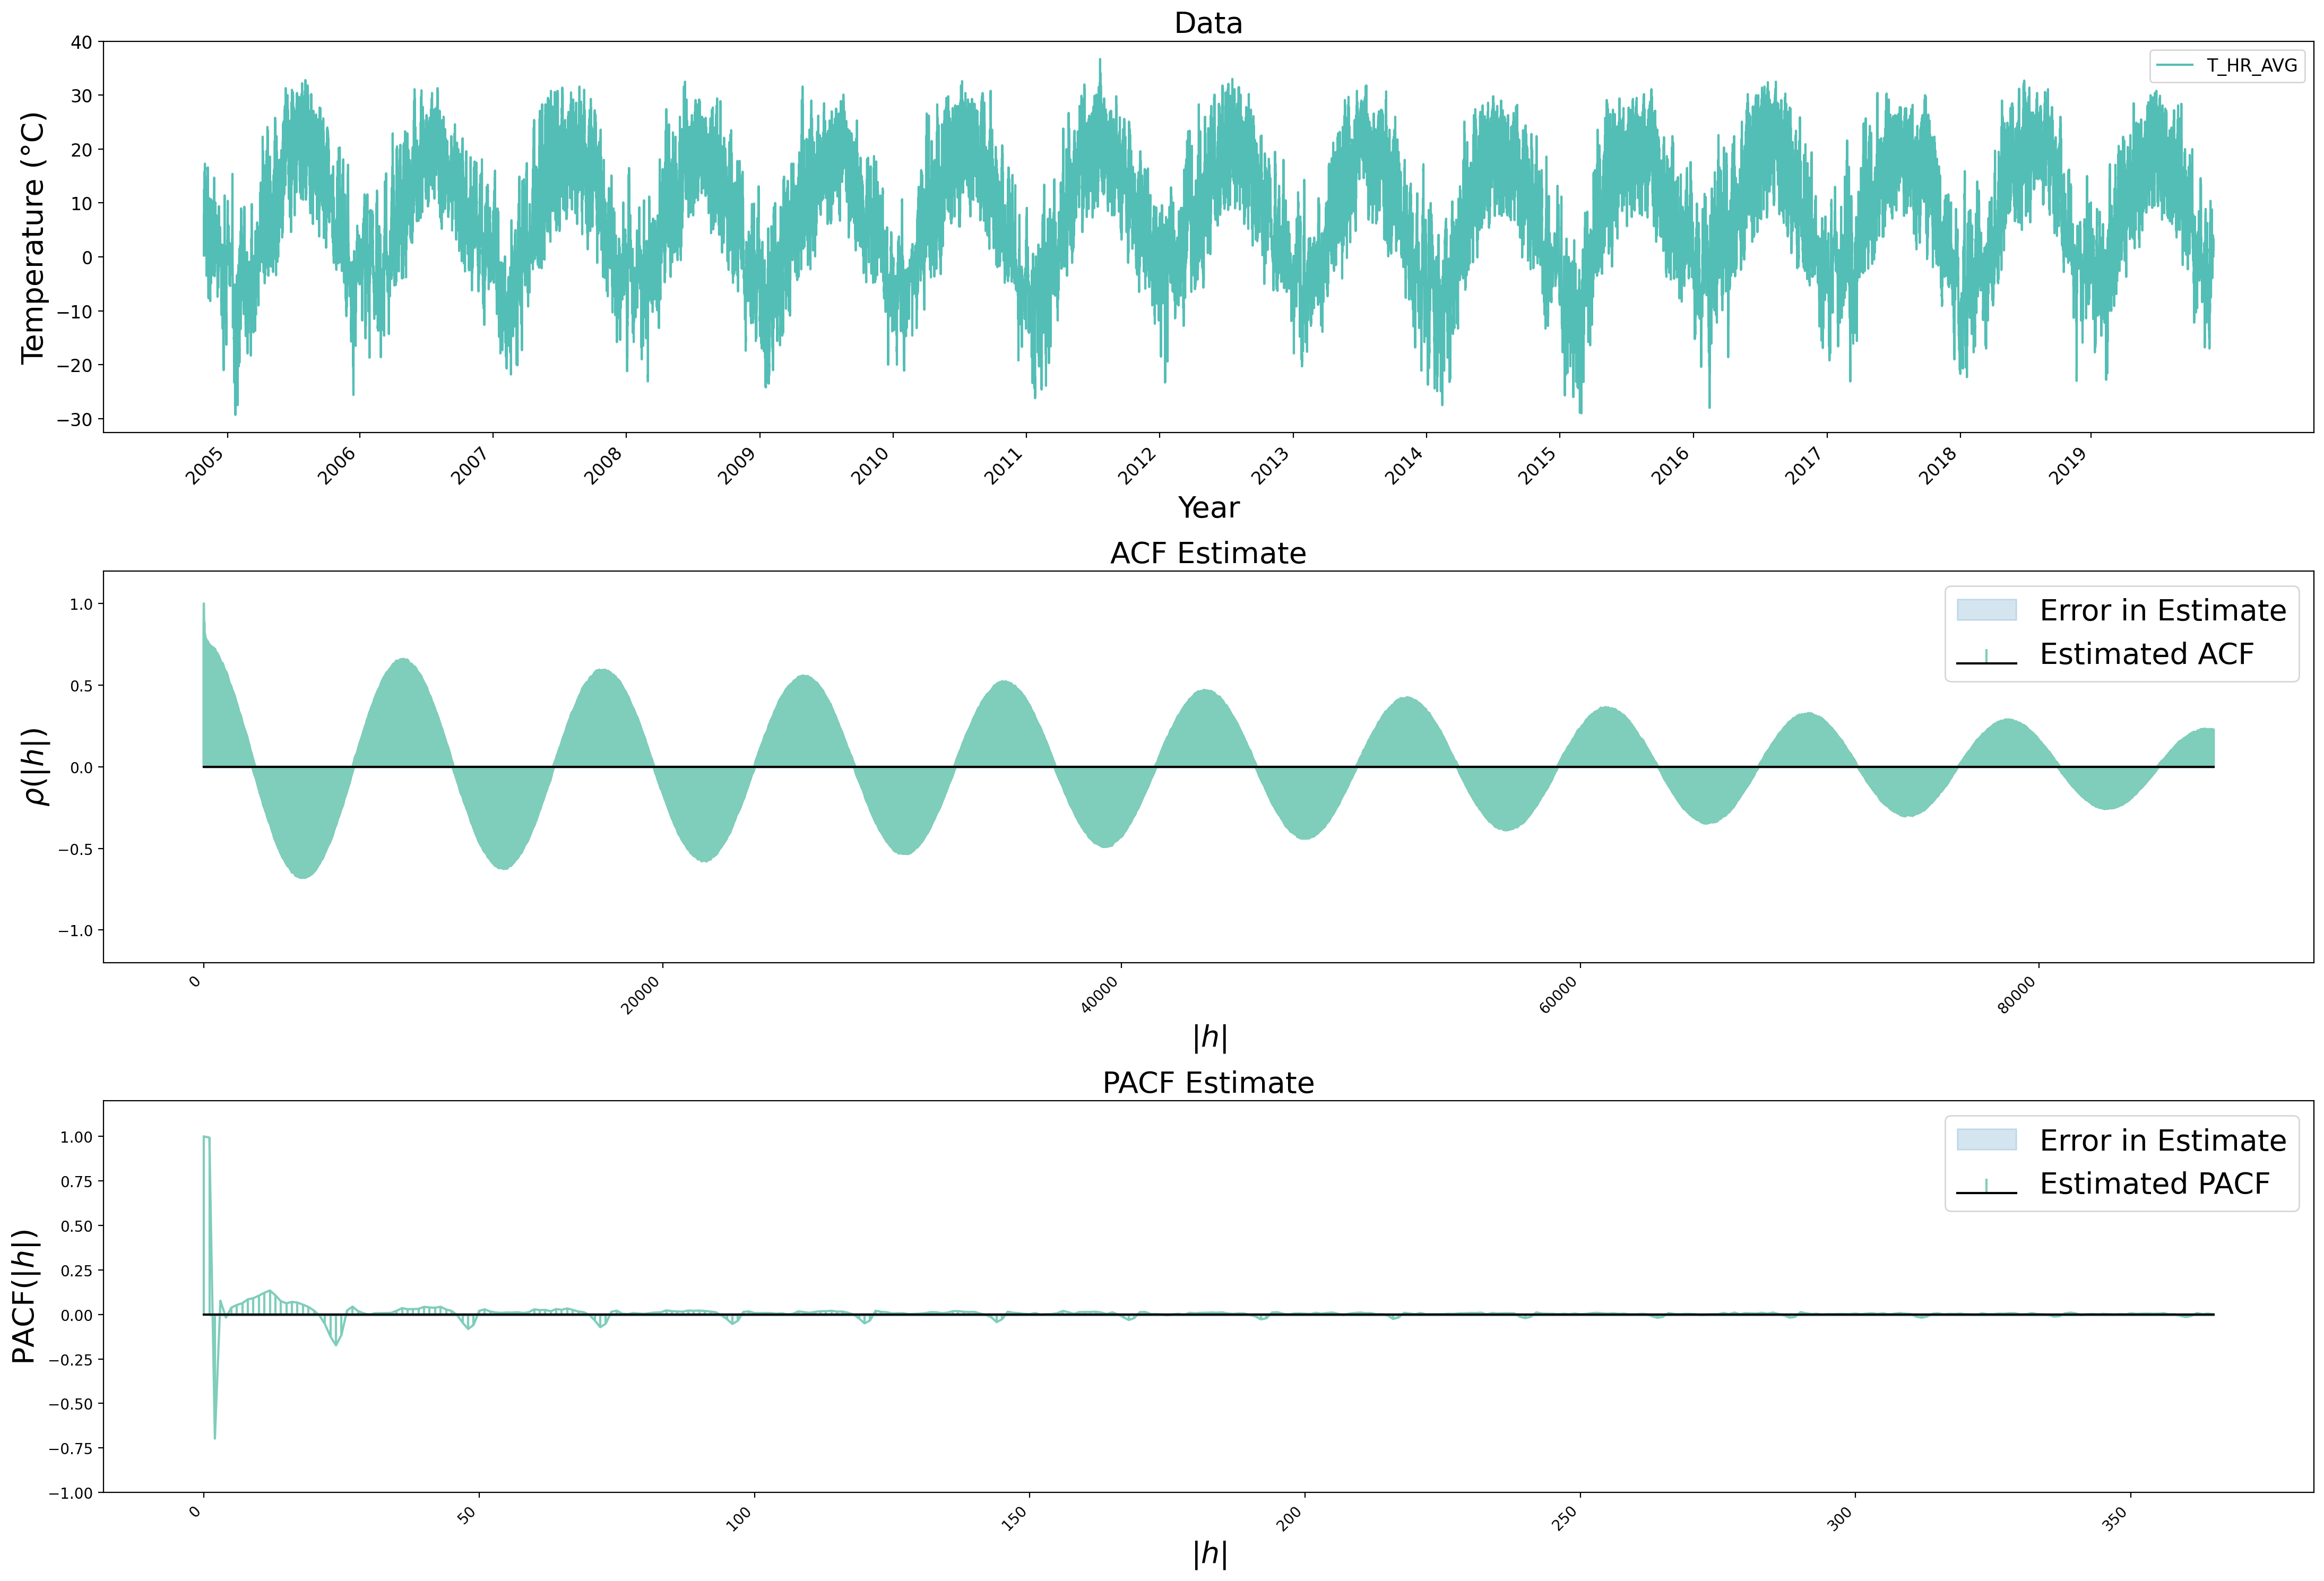

In [17]:
### Plot
plot_triple(Ithaca_hourly_train, n_lags_ar, n_lags_ma, acf_sm, pacf_sm, col = 'T_HR_AVG', fig_name = 'raw_data')

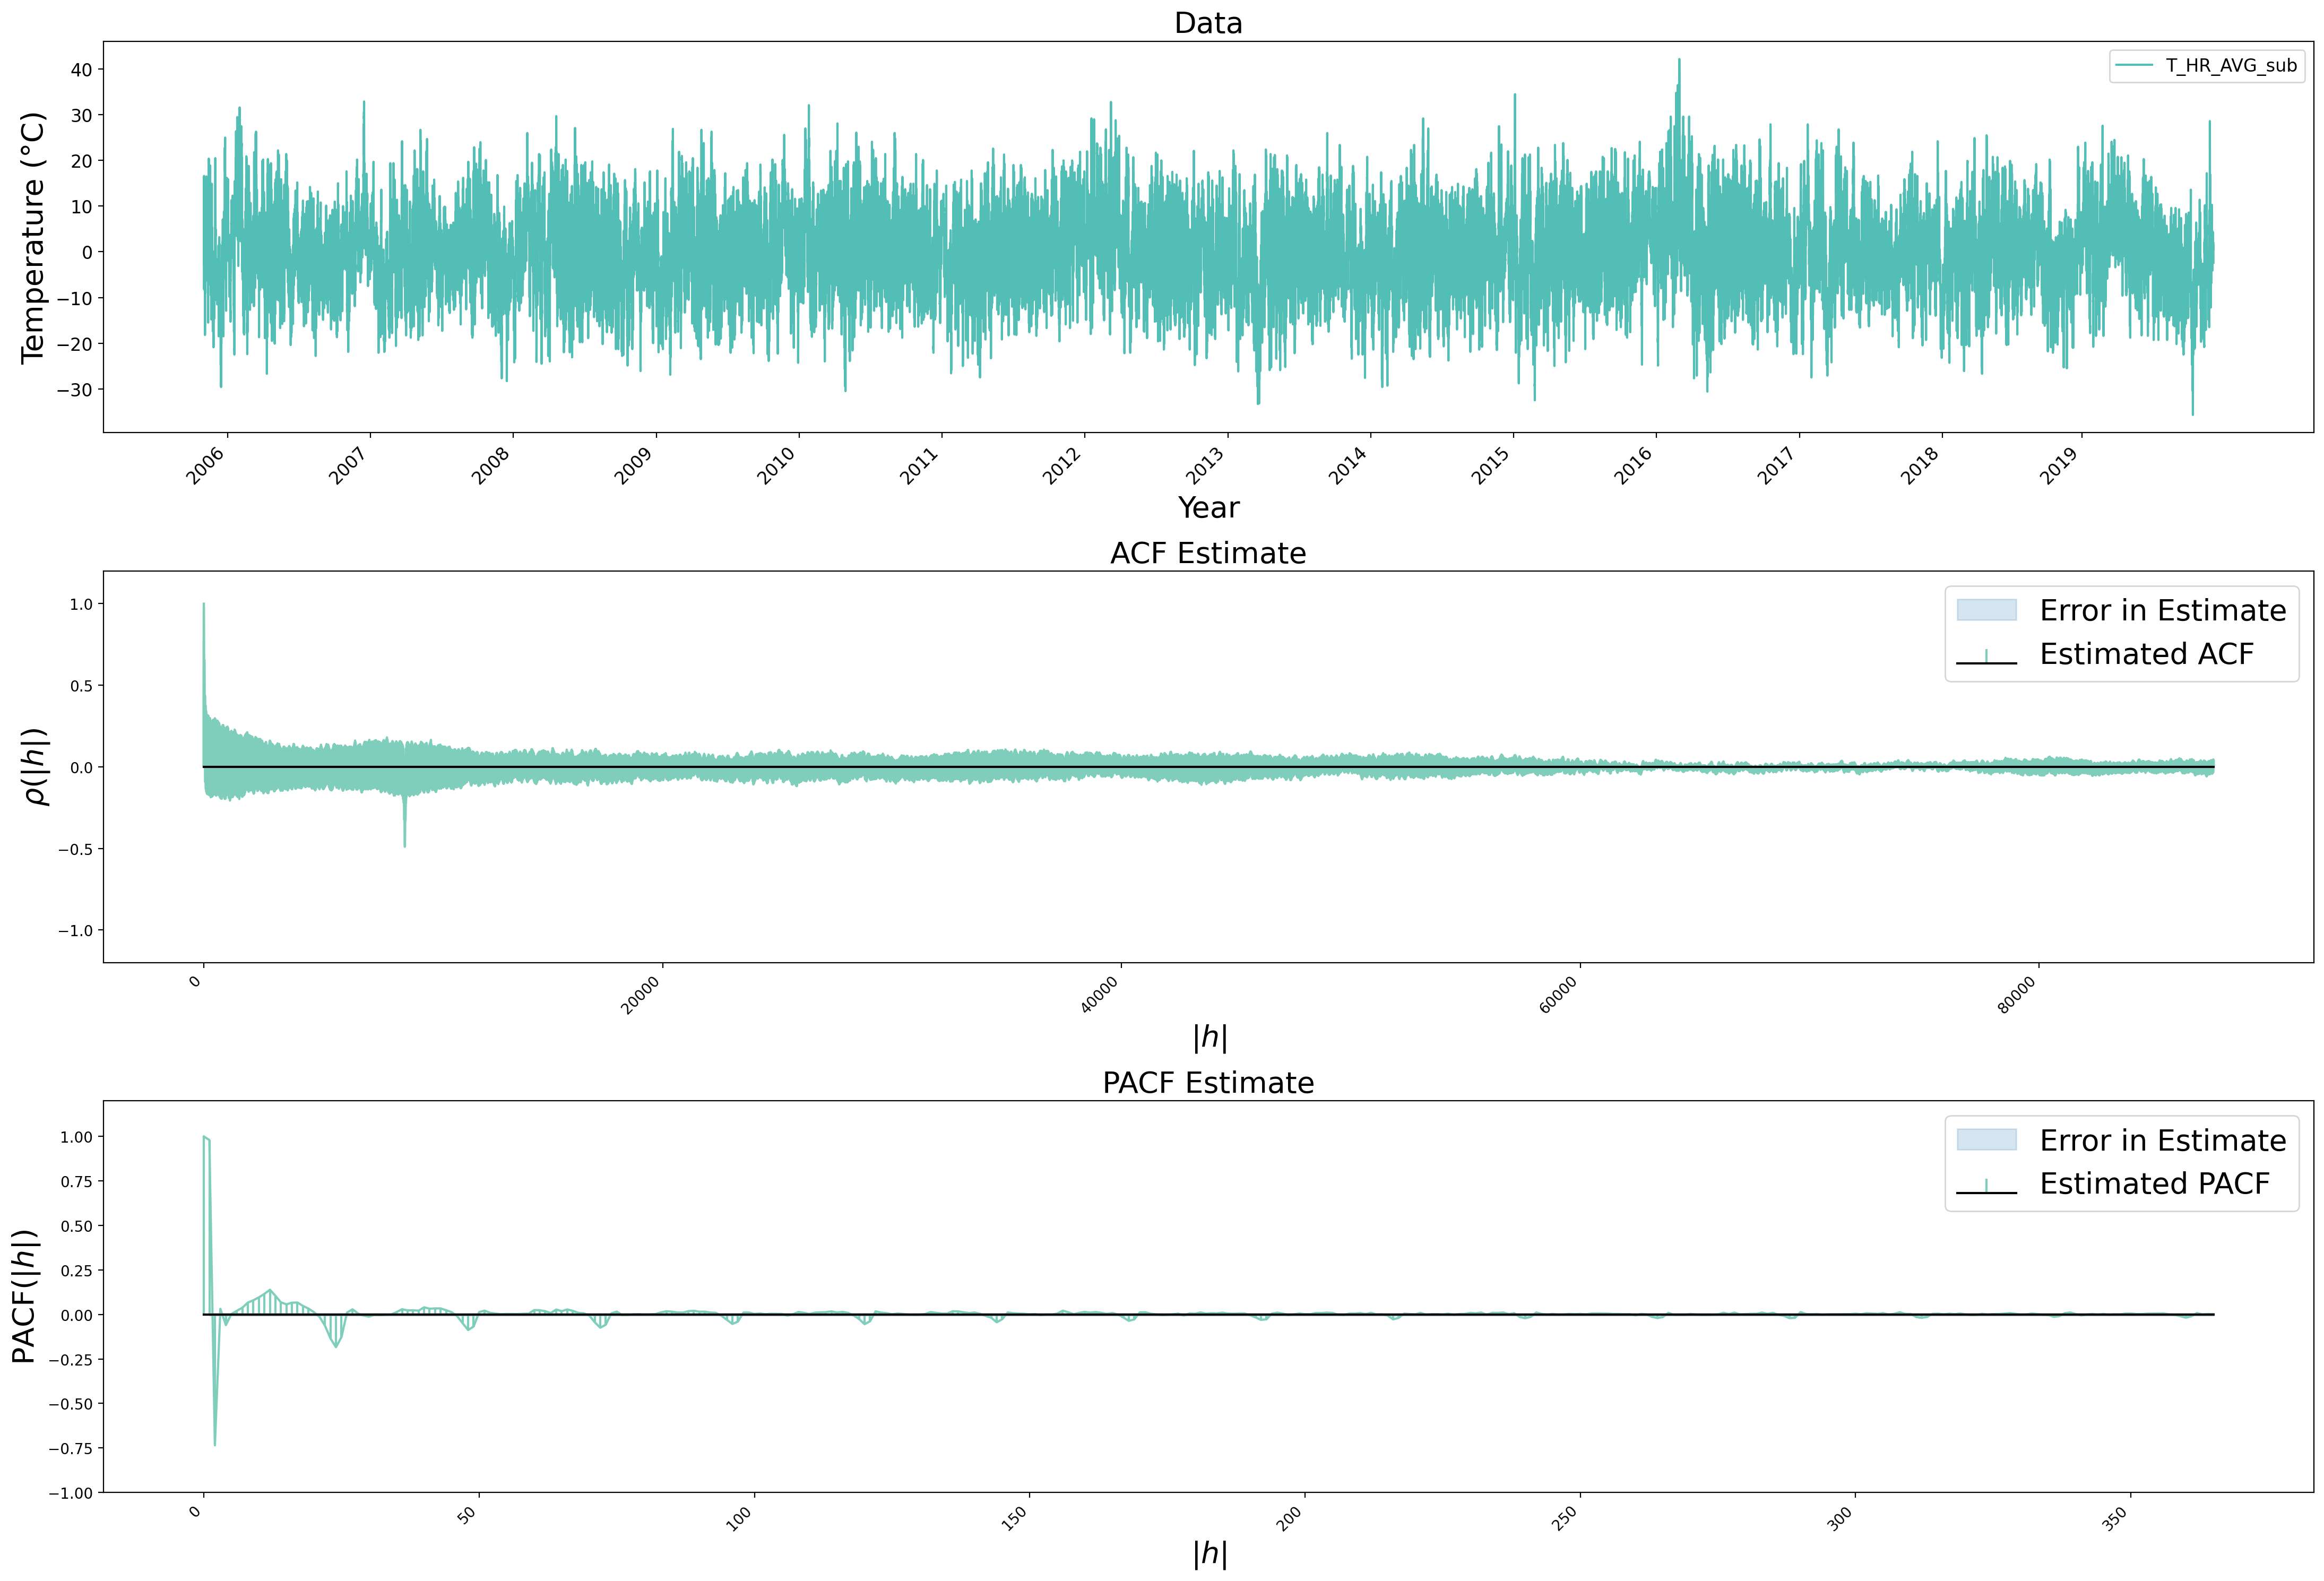

In [18]:
### plot without seasonality
# suggest seasonality of 356*24 = 8760
# let's remove seasonality by subtraction, as per pts4
seasonality = 8760
Ithaca_hourly_train_no_season = Ithaca_hourly_train.join(pd.DataFrame(Ithaca_hourly_train.T_HR_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()
n_lags_ar = 365*24*10
n_lags_ma = 365
acf_no_season_sm = acf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ar)
pacf_no_season_sm = pacf(Ithaca_hourly_train_no_season.T_HR_AVG_sub, nlags = n_lags_ma)

plot_triple(Ithaca_hourly_train_no_season, n_lags_ar, n_lags_ma, acf_sm = acf_no_season_sm,
            pacf_sm = pacf_no_season_sm, col = 'T_HR_AVG_sub', fig_name = 'drop_seasonality')

In [19]:
### check stationarity
adfuller(Ithaca_hourly_train_no_season.T_HR_AVG_sub) # seem to be stationary

(-29.73253901386201,
 0.0,
 72,
 123038,
 {'1%': -3.4304031497296332,
  '5%': -2.861563491396274,
  '10%': -2.5667825036397725},
 365694.86750573805)

#### 2. Deal with P, Q (seasonal AR & MA), as per [pts4](http://www.stat.ucla.edu/~frederic/221/W21/tsa4.pdf)
- Seems to lead to more satisfactory results if deal with seasonal first

In [20]:
seasonality = 8760
# acf_seasonal = acf_no_season_sm[::seasonality]
# pacf_seasonal = pacf(Ithaca_hourly_train_no_season.T_HR_AVG_sub,  nlags = seasonality//10) # really computationally expensive

In [ ]:
## plot
plot_triple_built_in(df = Ithaca_hourly_train_no_season,
                     n_lags_ar = seasonality * 10, n_lags_ma = 24*100,
                     seasonality = seasonality,
                     col = 'T_HR_AVG_sub',fig_name = 'seasonal_P_Q')
# suggests Q <=1, but P? suggests 0 AR(P)? Let's just try it. Or take a look at daily?

#### 3. Deal with daily

##### 3.1 take a look at daily TAVG to determine AR(P) (i.e., seasonal autoregressive process)

In [16]:
Ithaca_daily.Time = pd.to_datetime(Ithaca_daily.Time, format = '%Y-%m-%d', errors = 'coerce')
Ithaca_daily_train = Ithaca_daily[Ithaca_daily.Time.dt.year < 2020]
Ithaca_daily_val = Ithaca_daily[Ithaca_daily.Time.dt.year >=2020]
print(f'training set length = {Ithaca_daily_train.shape[0]}\n val set length = {Ithaca_daily_val.shape[0]}')

training set length = 5510
 val set length = 1399


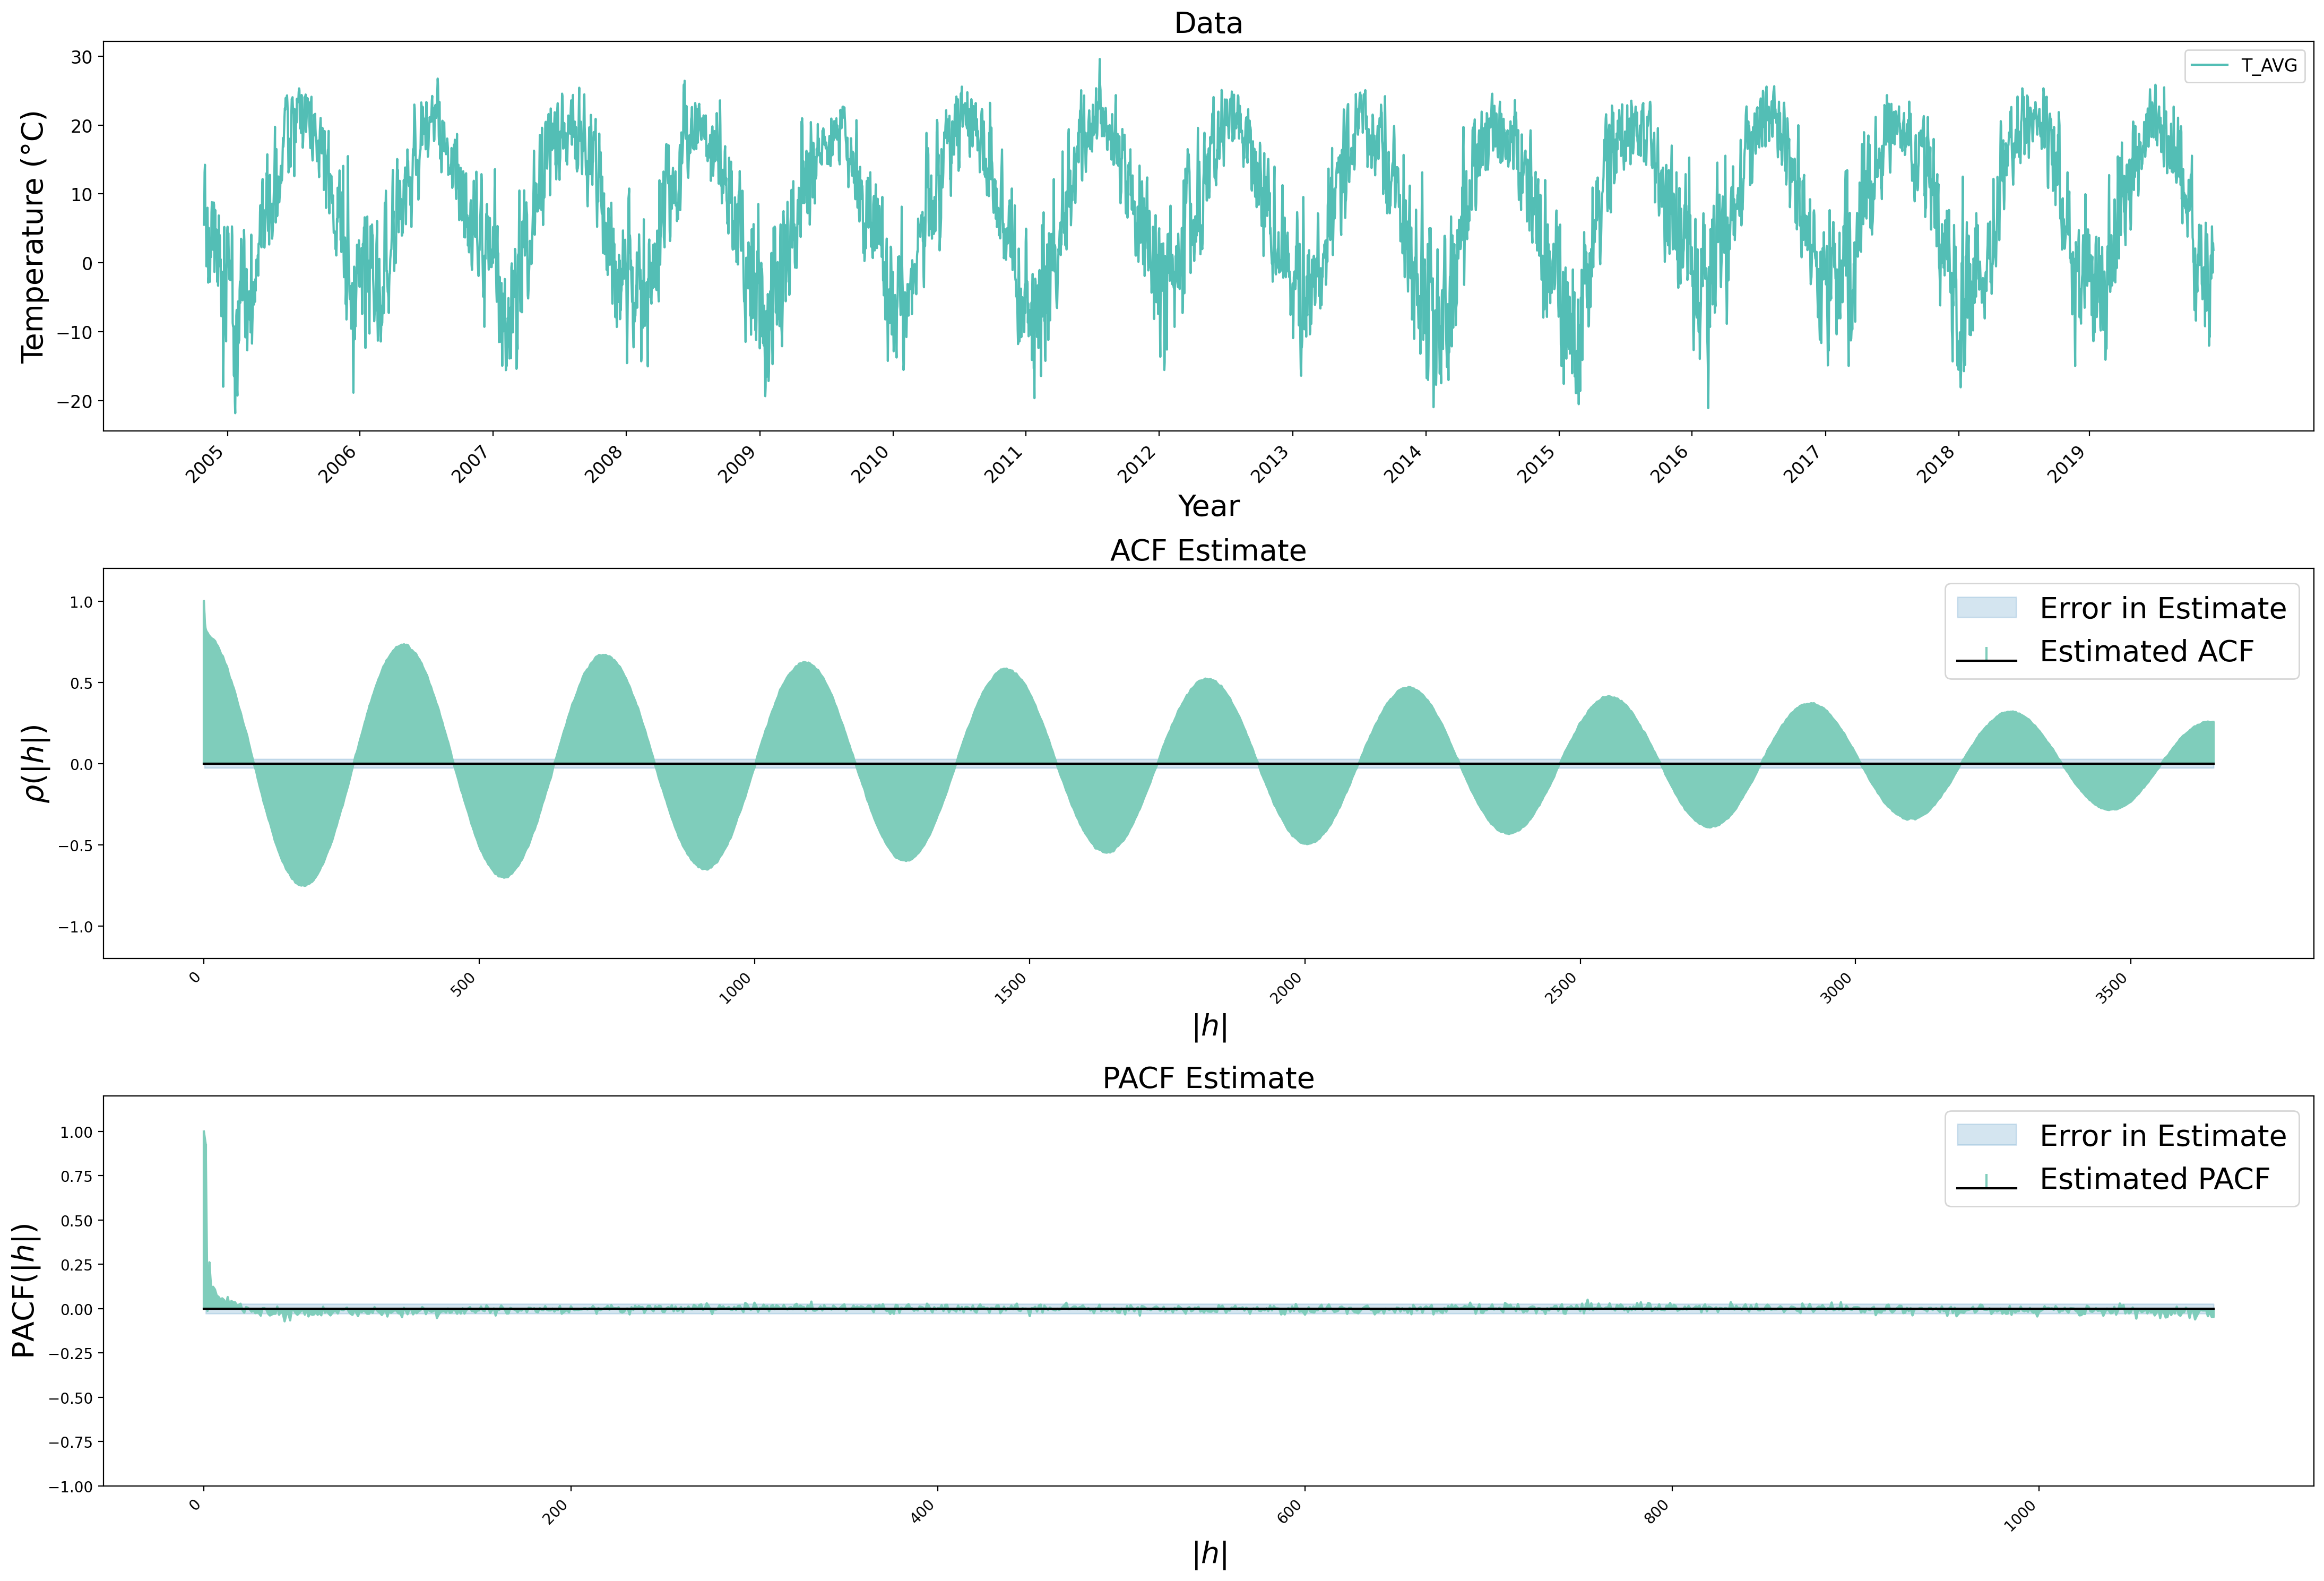

In [17]:
n_lags_ar = 365*10
n_lags_ma = 365*3
acf_daily_sm = acf(Ithaca_daily_train.T_AVG, nlags = n_lags_ar)
pacf_daily_sm = pacf(Ithaca_daily_train.T_AVG, nlags = n_lags_ma)

plot_triple(Ithaca_daily_train, n_lags_ar, n_lags_ma, acf_sm = acf_daily_sm,
            pacf_sm = pacf_daily_sm, col = 'T_AVG', fig_name = 'Ithaca_daily_raw')

In [17]:
seasonality = 365
Ithaca_daily_train_no_season = Ithaca_daily_train.join(pd.DataFrame(Ithaca_daily_train.T_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()

adfuller(Ithaca_daily_train_no_season.T_AVG_sub) # seem to be stationary

(-11.624643547320355,
 2.3395053902711815e-21,
 19,
 5125,
 {'1%': -3.4316266006519593,
  '5%': -2.862104122472345,
  '10%': -2.5670702825556218},
 30617.925638196415)

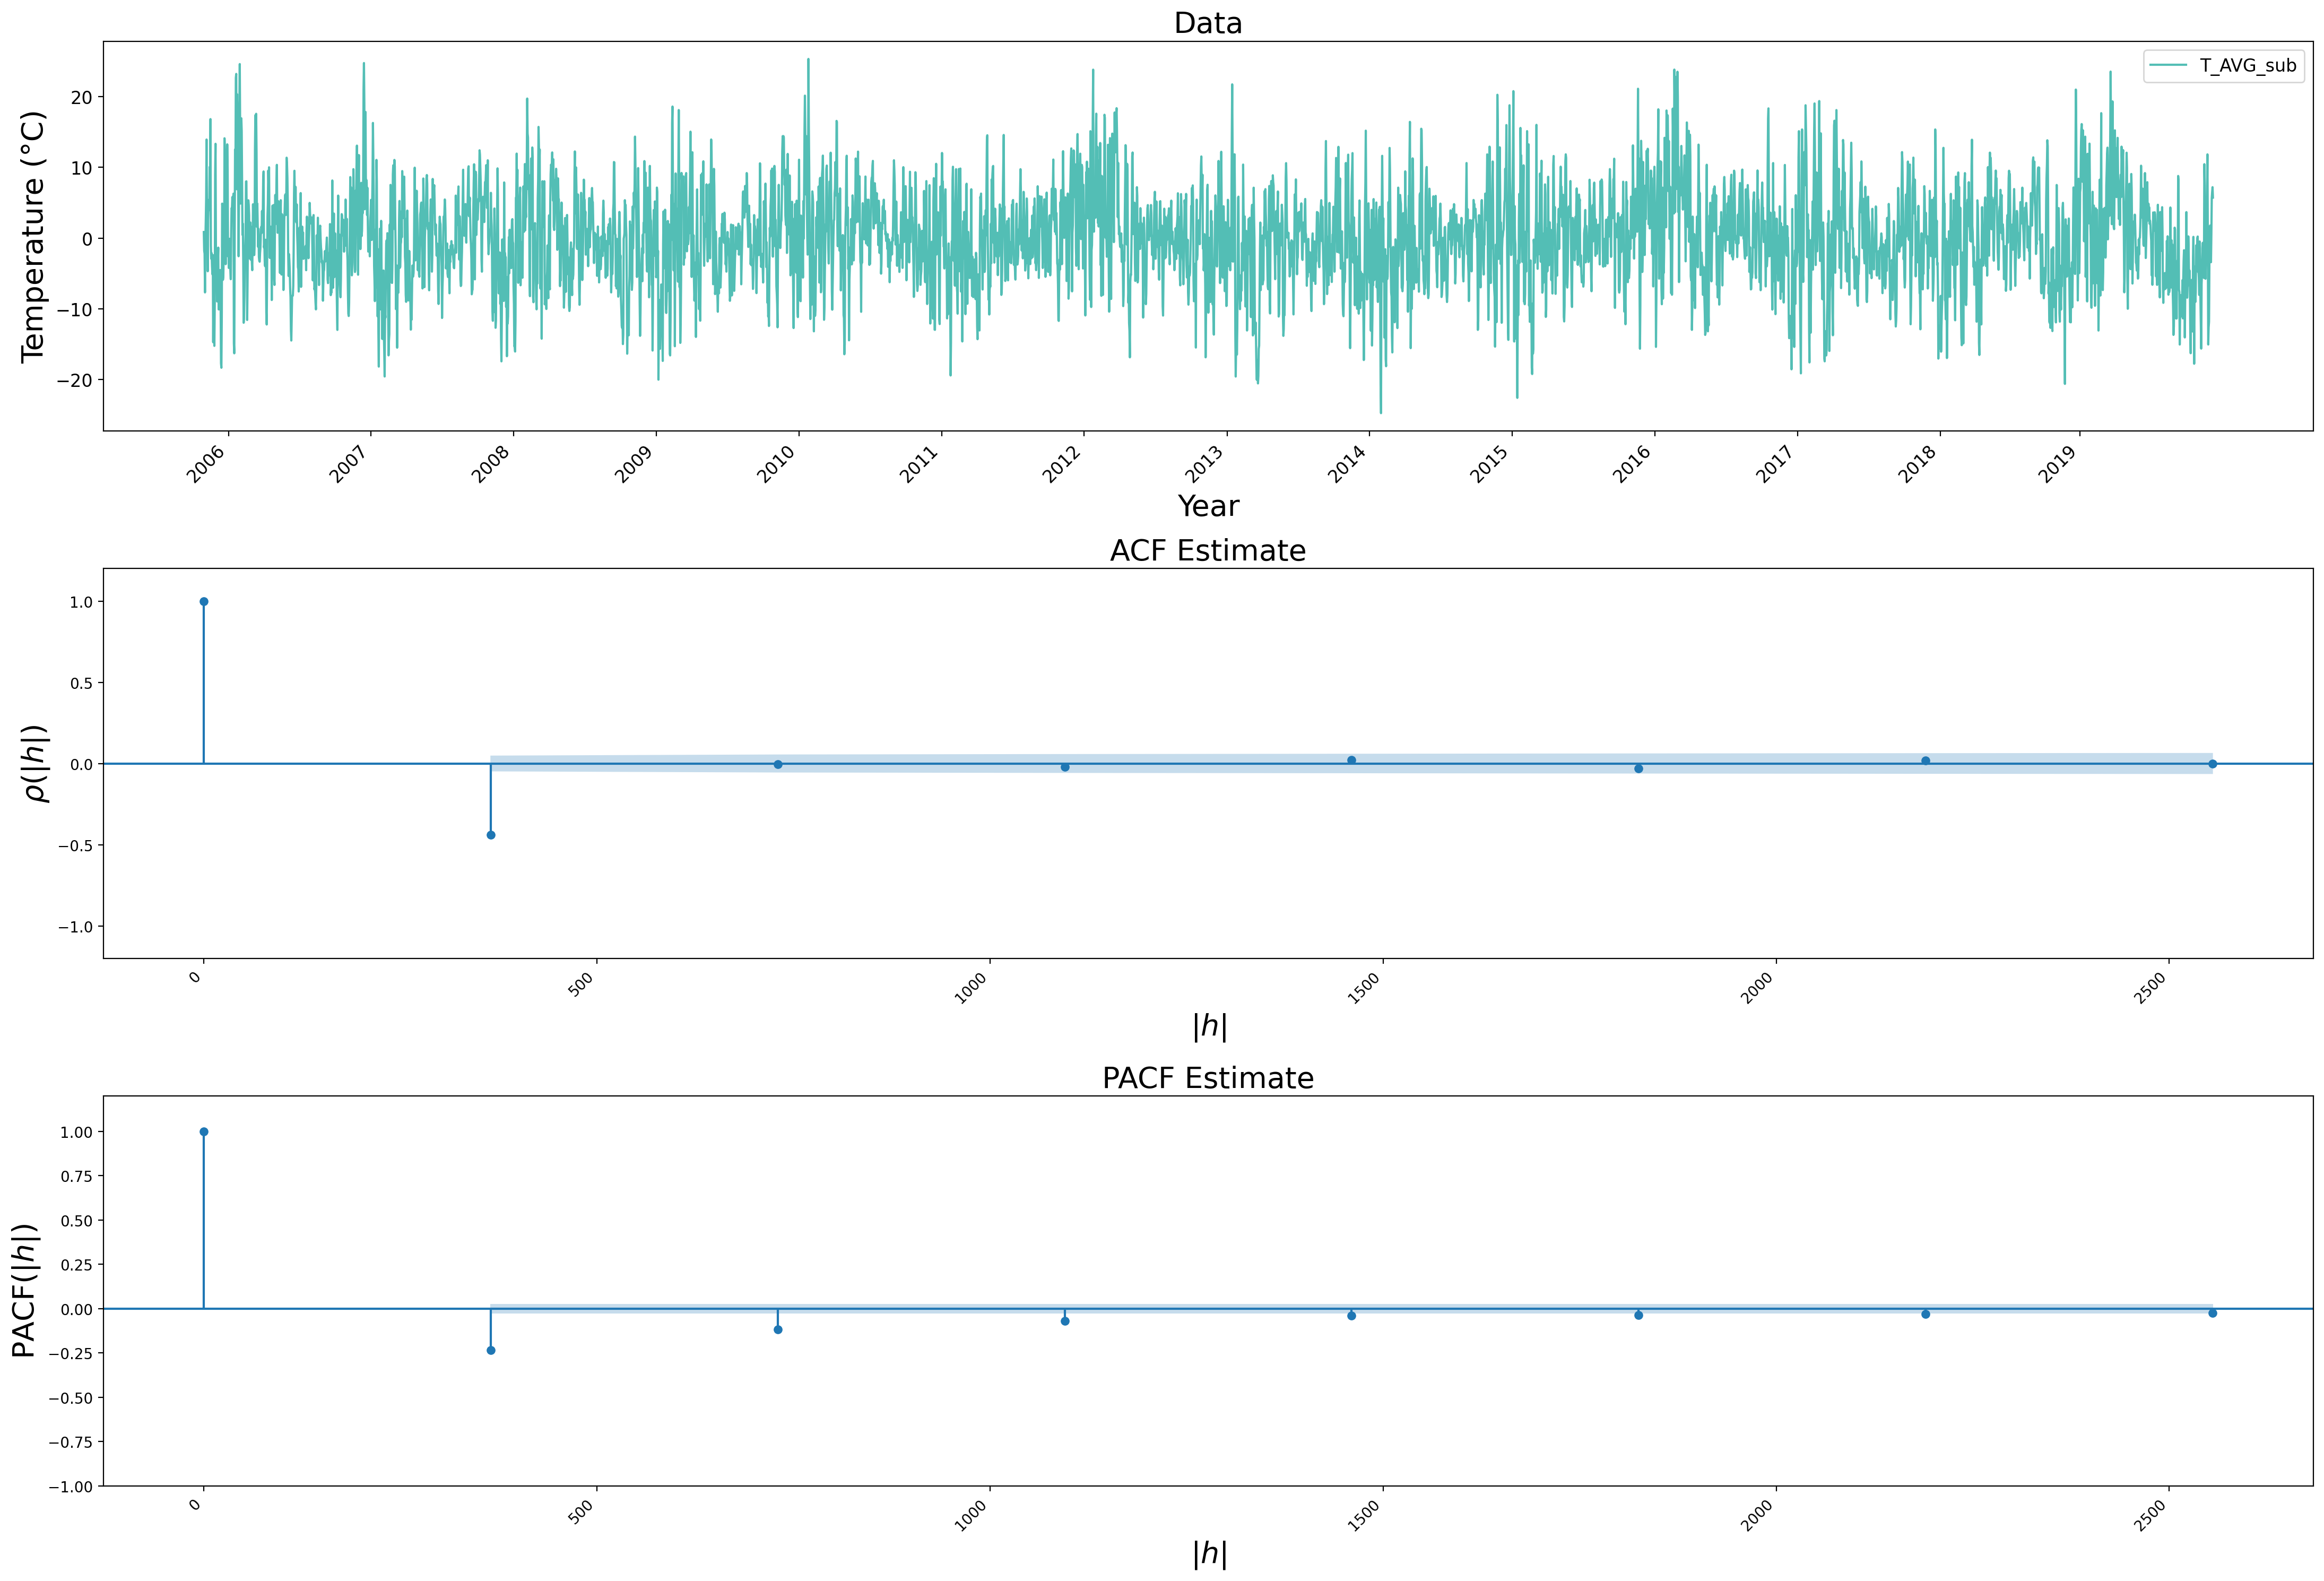

In [23]:
## Do not run. just keep the output

## plot
plot_triple_built_in(df = Ithaca_daily_train_no_season,
                     n_lags_ar = seasonality * 8, n_lags_ma = seasonality * 8,
                     seasonality = seasonality, lag_ma = seasonality,
                     col = 'T_AVG_sub',fig_name = 'daily_p_q')

# daily plot suggests Q <=1 & P <= 3, reducing our search space.

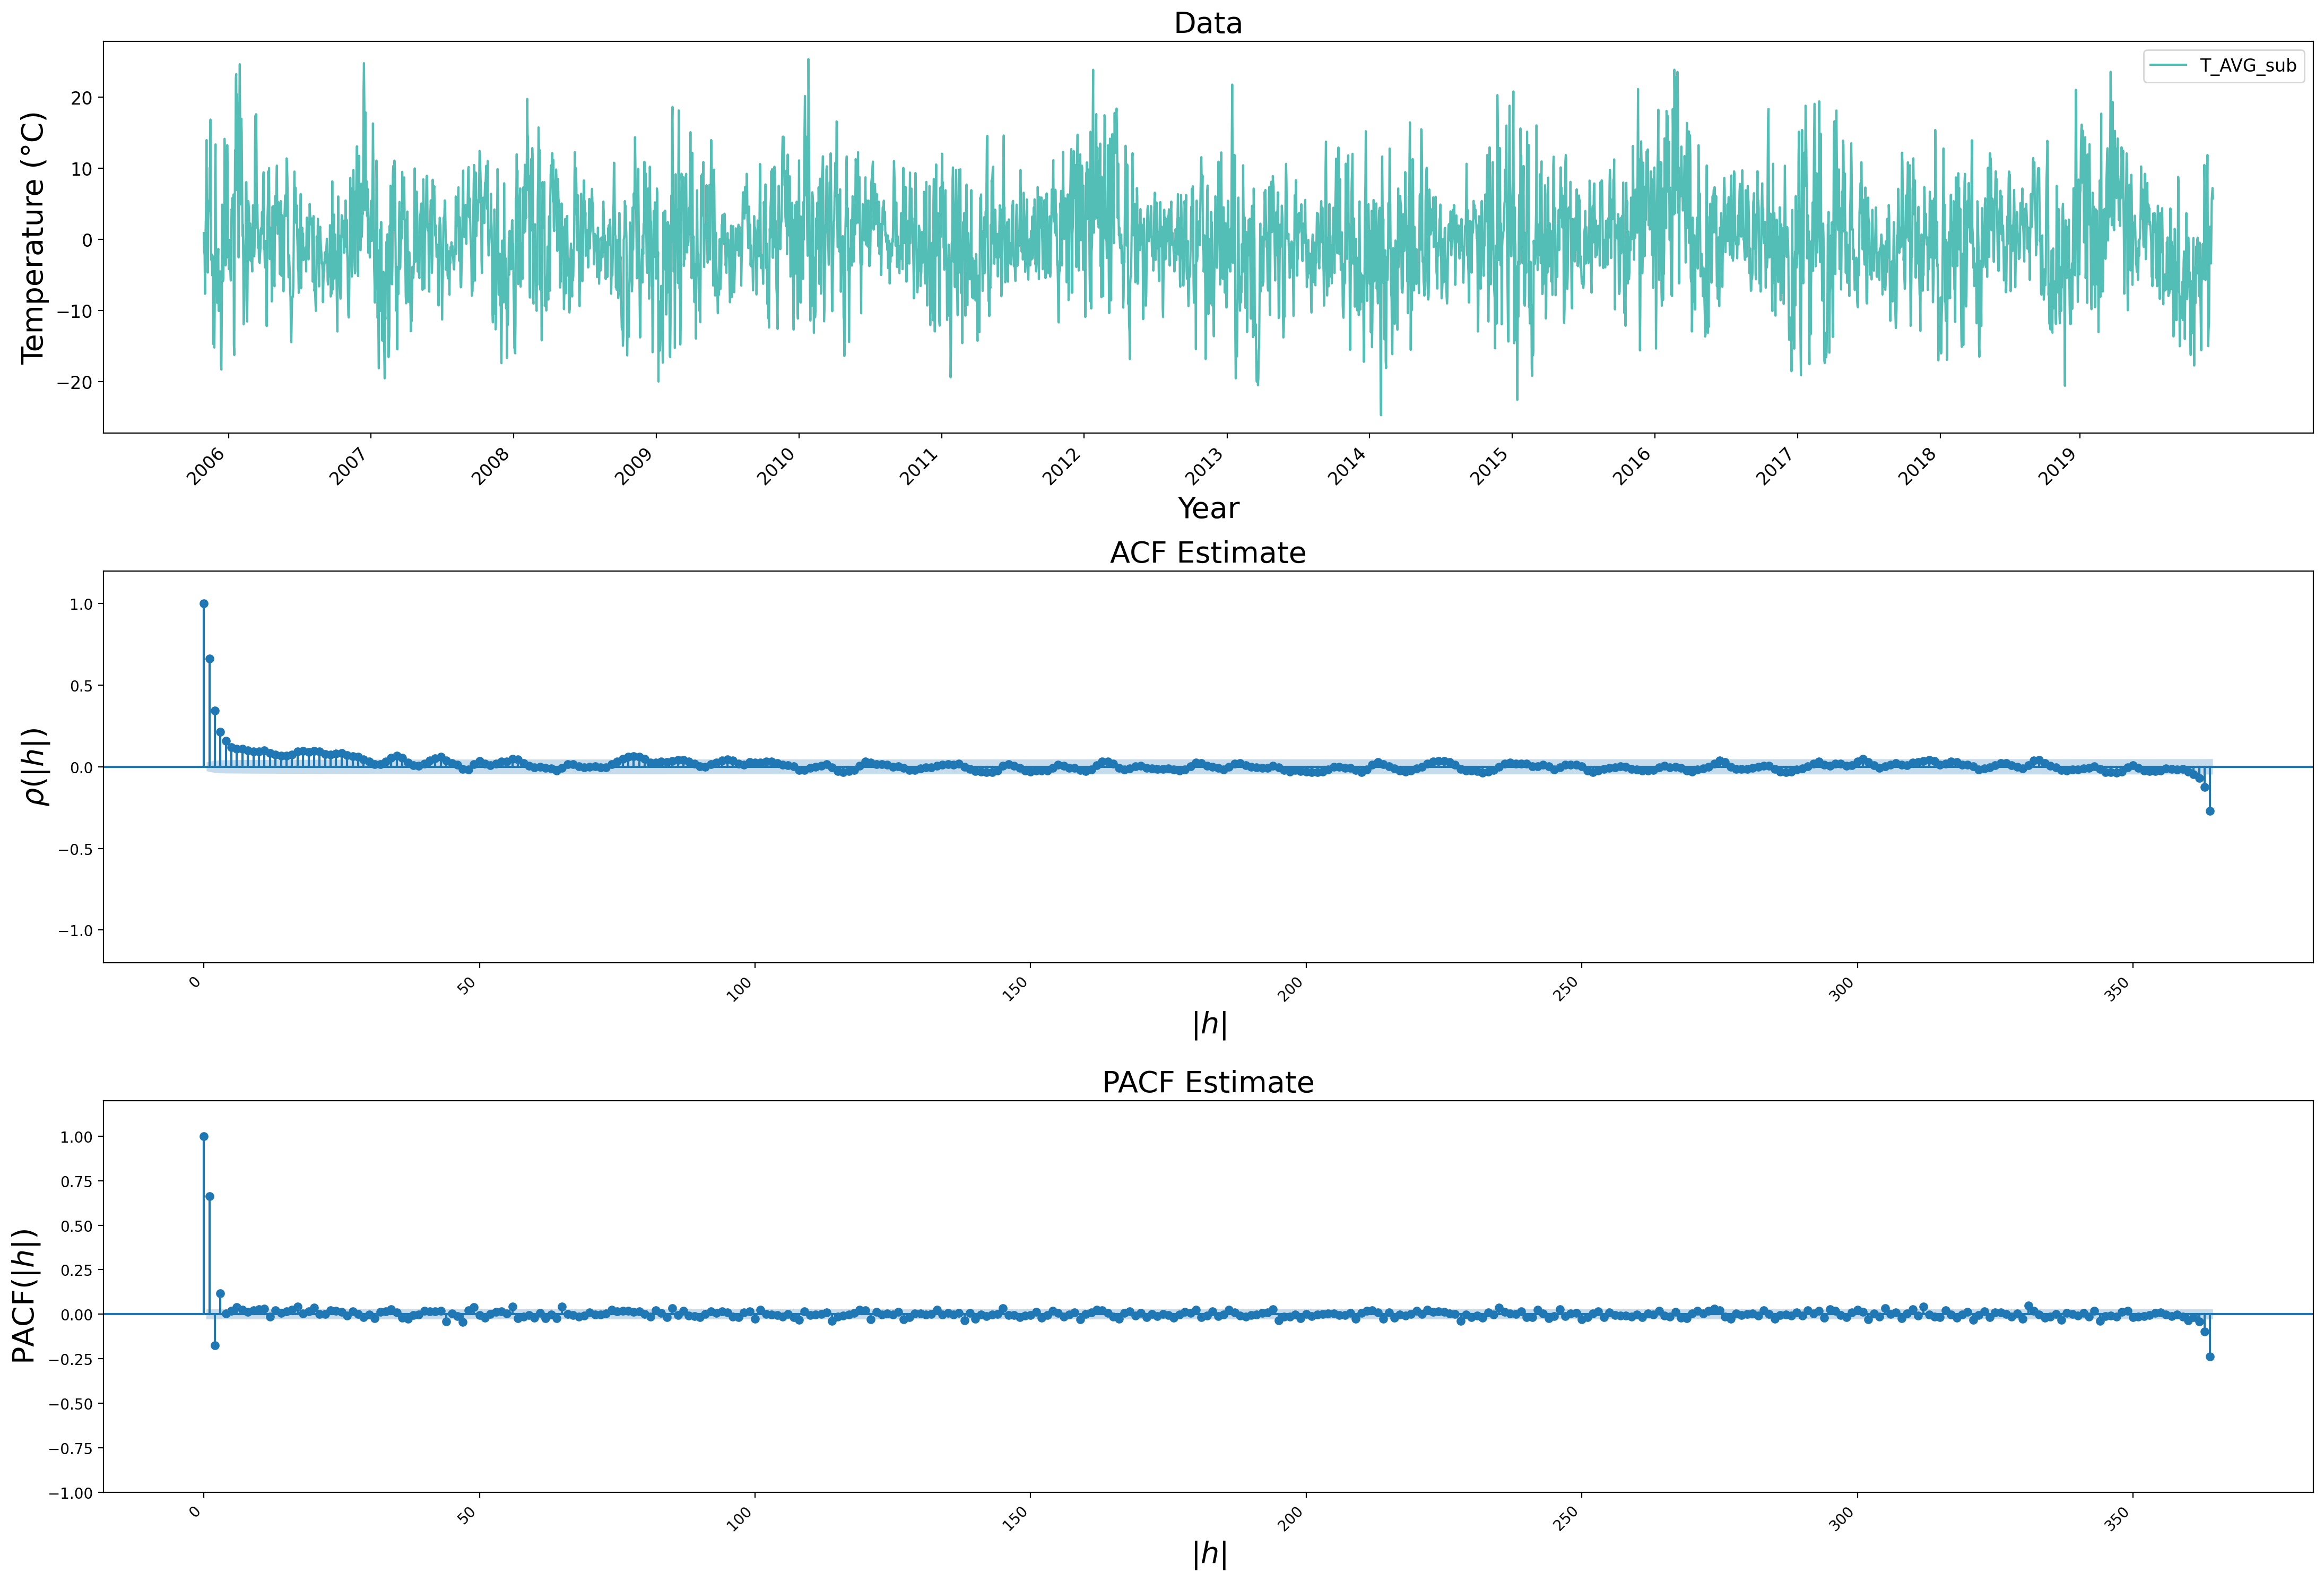

In [18]:
## Let's also draw acf & pacf in one cycle
plot_triple_built_in(df = Ithaca_daily_train_no_season,
                     n_lags_ar = seasonality, n_lags_ma = seasonality,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_AVG_sub',fig_name = 'daily_seasonal_P_Q')
## suggest MA(q): q<=26/7? AR(p): p<=3?

##### 3.2.1 FFT + ARMA

In [44]:
Ithaca_daily.Time = pd.to_datetime(Ithaca_daily.Time, format = '%Y-%m-%d', errors = 'coerce')
Ithaca_daily_train = Ithaca_daily[Ithaca_daily.Time.dt.year < 2020]
Ithaca_daily_val = Ithaca_daily[Ithaca_daily.Time.dt.year >=2020]
print(f'training set length = {Ithaca_daily_train.shape[0]}\n val set length = {Ithaca_daily_val.shape[0]}')

training set length = 5510
 val set length = 1399


In [45]:
signal = Ithaca_daily_train.T_AVG.values
dt = 1.0
freq, a_n, b_n = calculate_fourier_series(dt = dt, signal = signal)

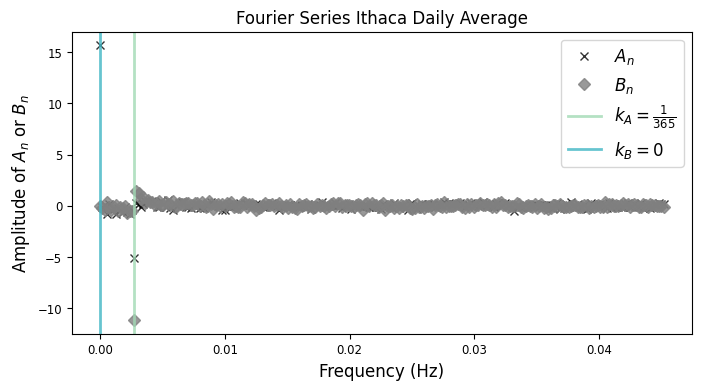

<Figure size 432x288 with 0 Axes>

In [46]:
frequencies_to_plot = freq[:250].reshape(-1,1)
a_n_to_plot = a_n[:250].reshape(-1,1)
b_n_to_plot = b_n[:250].reshape(-1,1)
k_a = 1/365
k_b = 0
# k_c = 1/(160)

plt.figure(figsize=(8,4), dpi=100)
colors = ['black','grey']
plt.plot(frequencies_to_plot, a_n_to_plot, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
plt.plot(frequencies_to_plot, b_n_to_plot, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)

colors_freq = ['#a1dab4', '#41b6c4', '#225ea8']
plt.axvline(k_a, label=r'$k_{A} = \frac{1}{365}$', color=colors_freq[0], lw=2, alpha=0.8)
plt.axvline(k_b, label=r'$k_{B} = 0$', color=colors_freq[1], lw=2, alpha=0.8)
# plt.axvline(k_c, label=r'$k_{C} = \frac{1}{(365/2)}$', color=colors_freq[2], lw=2, alpha=0.8)

plt.legend(fontsize=12)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=12)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.tick_params(axis='both', labelsize=12 * 0.7)
plt.title('Fourier Series Ithaca Daily Average', fontsize=12)
plt.show()

plt.savefig(f'{os.getcwd()}/daily_fourier_series.png', bbox_inches = 'tight')

In [47]:
mask = np.zeros(len(signal))
# to_keep = np.array([int(len(signal)* k_a), int(len(signal) * k_b), 
#                     -int(len(signal) * k_a), -int(len(signal) * k_b)])

to_keep = np.argsort(a_n**2 + b_n**2)[::-1][:100]
# to_keep = np.argsort(abs(a_n) + abs(b_n))[::-1][:50]

mask[to_keep] = 1
mask[-to_keep] = 1

Ithaca_daily_train_recon = reconstructed_signal(frequency_mask = mask, signal = signal)
Ithaca_daily_train_recon

array([5.05170031, 5.92883608, 6.31169581, ..., 1.08476847, 2.45442803,
       3.84206041])

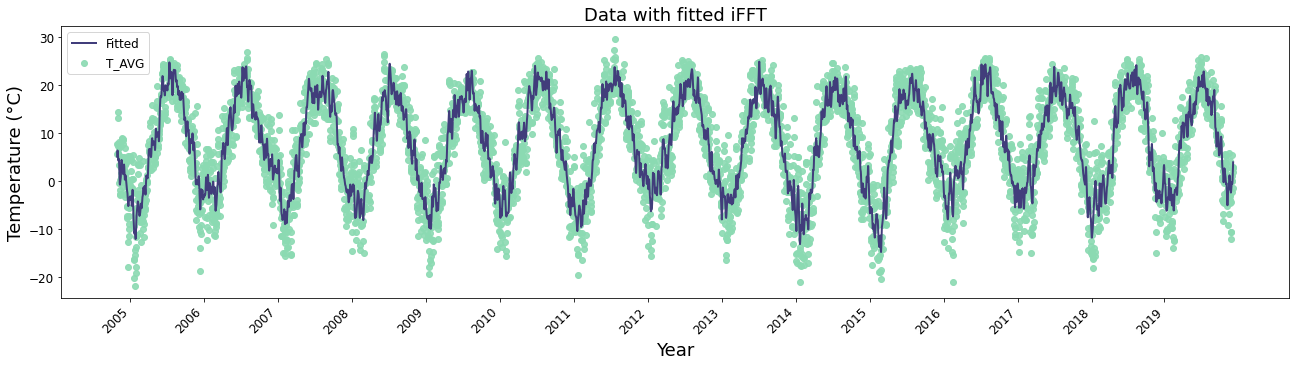

In [48]:
## plot
fig, ax = plt.subplots(1,1, figsize = (22,5))

fontsize = 18
labelsize = 12
colors = ['#7fcdbb', '#2c7fb8']
palette = sns.color_palette("mako_r", 6)
df = Ithaca_daily_train
col = 'T_AVG'
years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

ax.set_title('Data with fitted iFFT', fontsize=fontsize)
ax.scatter(df.index, df.T_AVG, label='T_AVG', color = palette[0], alpha = 0.9)
ax.plot(df.index, Ithaca_daily_train_recon, color = palette[-2], lw = 2, label = 'Fitted')
ax.set_xticklabels([])
ax.set_xticks(years[1:])
ax.set_xticklabels(years_txt[1:], rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=fontsize)
ax.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
ax.legend(fontsize=12)
fig.savefig('iFFT_data.png')

In [49]:
signal = Ithaca_daily_val.T_AVG
dt = 1.0
freq, a_n, b_n = calculate_fourier_series(dt = dt, signal = signal)

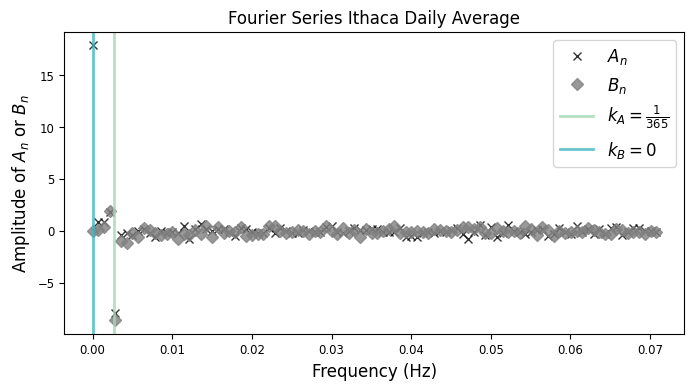

<Figure size 432x288 with 0 Axes>

In [50]:
frequencies_to_plot = freq[:100].reshape(-1,1)
a_n_to_plot = a_n[:100].reshape(-1,1)
b_n_to_plot = b_n[:100].reshape(-1,1)
k_a = 1/365
k_b = 0
# k_c = 1/(365//2)

plt.figure(figsize=(8,4), dpi=100)
colors = ['black','grey']
plt.plot(frequencies_to_plot, a_n_to_plot, 'x', label=r'$A_n$', color=colors[0], ms=6, alpha=0.8)
plt.plot(frequencies_to_plot, b_n_to_plot, 'D', label=r'$B_n$', color=colors[1], ms=6, alpha=0.8)

colors_freq = ['#a1dab4', '#41b6c4', '#225ea8']
plt.axvline(k_a, label=r'$k_{A} = \frac{1}{365}$', color=colors_freq[0], lw=2, alpha=0.8)
plt.axvline(k_b, label=r'$k_{B} = 0$', color=colors_freq[1], lw=2, alpha=0.8)
# plt.axvline(k_c, label=r'$k_{C} = \frac{1}{(365/2)}$', color=colors_freq[2], lw=2, alpha=0.8)

plt.legend(fontsize=12)
plt.ylabel(r'Amplitude of $A_n$ or $B_n$', fontsize=12)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.tick_params(axis='both', labelsize=12 * 0.7)
plt.title('Fourier Series Ithaca Daily Average', fontsize=12)
plt.show()

plt.savefig(f'{os.getcwd()}/daily_fourier_series_val.png', bbox_inches = 'tight')

In [51]:
mask = np.zeros(len(signal))
# to_keep = np.array([int(len(signal)* k_a), int(len(signal) * k_b), 
#                     -int(len(signal) * k_a), -int(len(signal) * k_b)])
to_keep = np.argsort(a_n**2 + b_n**2)[::-1][:100]
# to_keep = np.argsort(abs(a_n) + abs(b_n))[::-1][:50]

mask[to_keep] = 1
mask[-to_keep] = 1


Ithaca_daily_val_recon = reconstructed_signal(frequency_mask = mask, signal = signal)
Ithaca_daily_val_recon

array([-0.41504307,  1.30285028,  3.51889835, ...,  6.09513626,
        4.24334069,  0.87369992])

##### 3.2.2 Just use apparent cycles

In [30]:
## assume omega = 2*pi/365
## https://www.youtube.com/watch?v=sa7E9qUHYXw&ab_channel=QuantPy
## we'are using the curve_fit to solve for non-linear fitting problem

# amptitude, shift, intercept
def trig_season(x, a, b, c):
  # a, b, c = params
  return a* np.sin(2*np.pi/365 *x + b) + c

params, param_cov = optimize.curve_fit(f = trig_season,
                   xdata = np.arange(len(Ithaca_daily_train)),
                   ydata = np.array(Ithaca_daily_train.T_AVG))
params

array([-12.58814598,   6.4131982 ,   7.85780641])

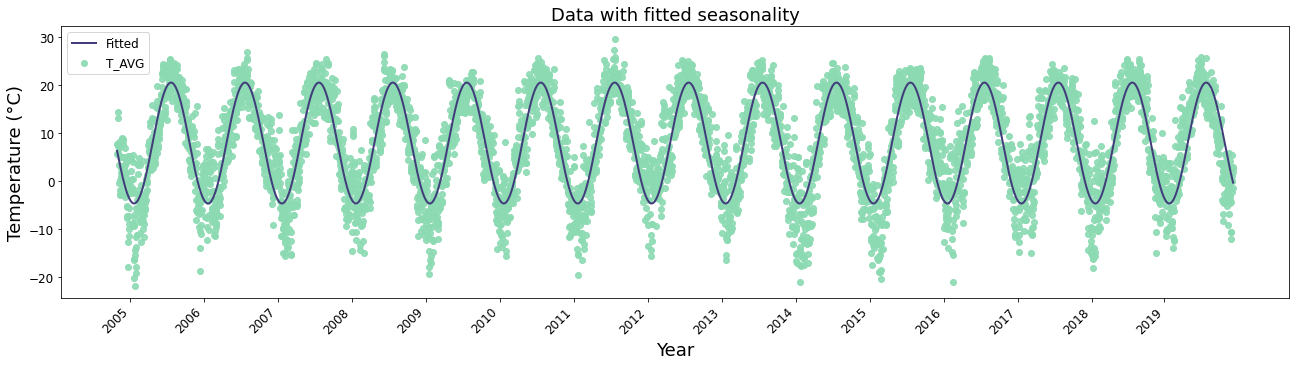

In [31]:
## plot
fig, ax = plt.subplots(1,1, figsize = (22,5))

fontsize = 18
labelsize = 12
colors = ['#7fcdbb', '#2c7fb8']
palette = sns.color_palette("mako_r", 6)
df = Ithaca_daily_train
col = 'T_AVG'
years_txt, years = np.unique(df['Time'].dt.year, return_index=True)

ax.set_title('Data with fitted seasonality', fontsize=fontsize)
ax.scatter(df.index, df.T_AVG, label='T_AVG', color = palette[0], alpha = 0.9)
ax.plot(df.index, trig_season(df.index, params[0], params[1], params[2]), color = palette[-2], lw = 2, label = 'Fitted')
ax.set_xticklabels([])
ax.set_xticks(years[1:])
ax.set_xticklabels(years_txt[1:], rotation=45, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=fontsize)
ax.set_xlabel('Year', fontsize=fontsize, labelpad=5.0)
ax.legend(fontsize=12)
fig.savefig('Trig_data.png')

##### 3.2.3 subtract $X_{T-365}$

In [32]:
seasonality = 365
Ithaca_daily_train_no_season = Ithaca_daily_train.join(pd.DataFrame(Ithaca_daily_train.T_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()
Ithaca_daily_val_temp = pd.concat([Ithaca_daily_train.iloc[-seasonality:], Ithaca_daily_val], axis = 0)
Ithaca_daily_val_no_season = Ithaca_daily_val_temp.join(pd.DataFrame(Ithaca_daily_val_temp.T_AVG.diff(seasonality).dropna()),
                                             how = 'right', rsuffix = '_sub').reset_index()

##### 3.3 subtract seasonality, ADF, triplot

##### 3.3.1 FFT

In [54]:
## subtract reconstructed signal
Ithaca_daily_train['T_AVG_ifft_sub'] = Ithaca_daily_train.T_AVG - Ithaca_daily_train_recon
Ithaca_daily_val['T_AVG_ifft_sub'] = Ithaca_daily_val.T_AVG - Ithaca_daily_val_recon

# adf test
adfuller(Ithaca_daily_train.T_AVG_ifft_sub)

(-21.603637253095577,
 0.0,
 13,
 5496,
 {'1%': -3.4315403851621102,
  '5%': -2.8620660319694364,
  '10%': -2.5670500056584755},
 28231.950256584947)

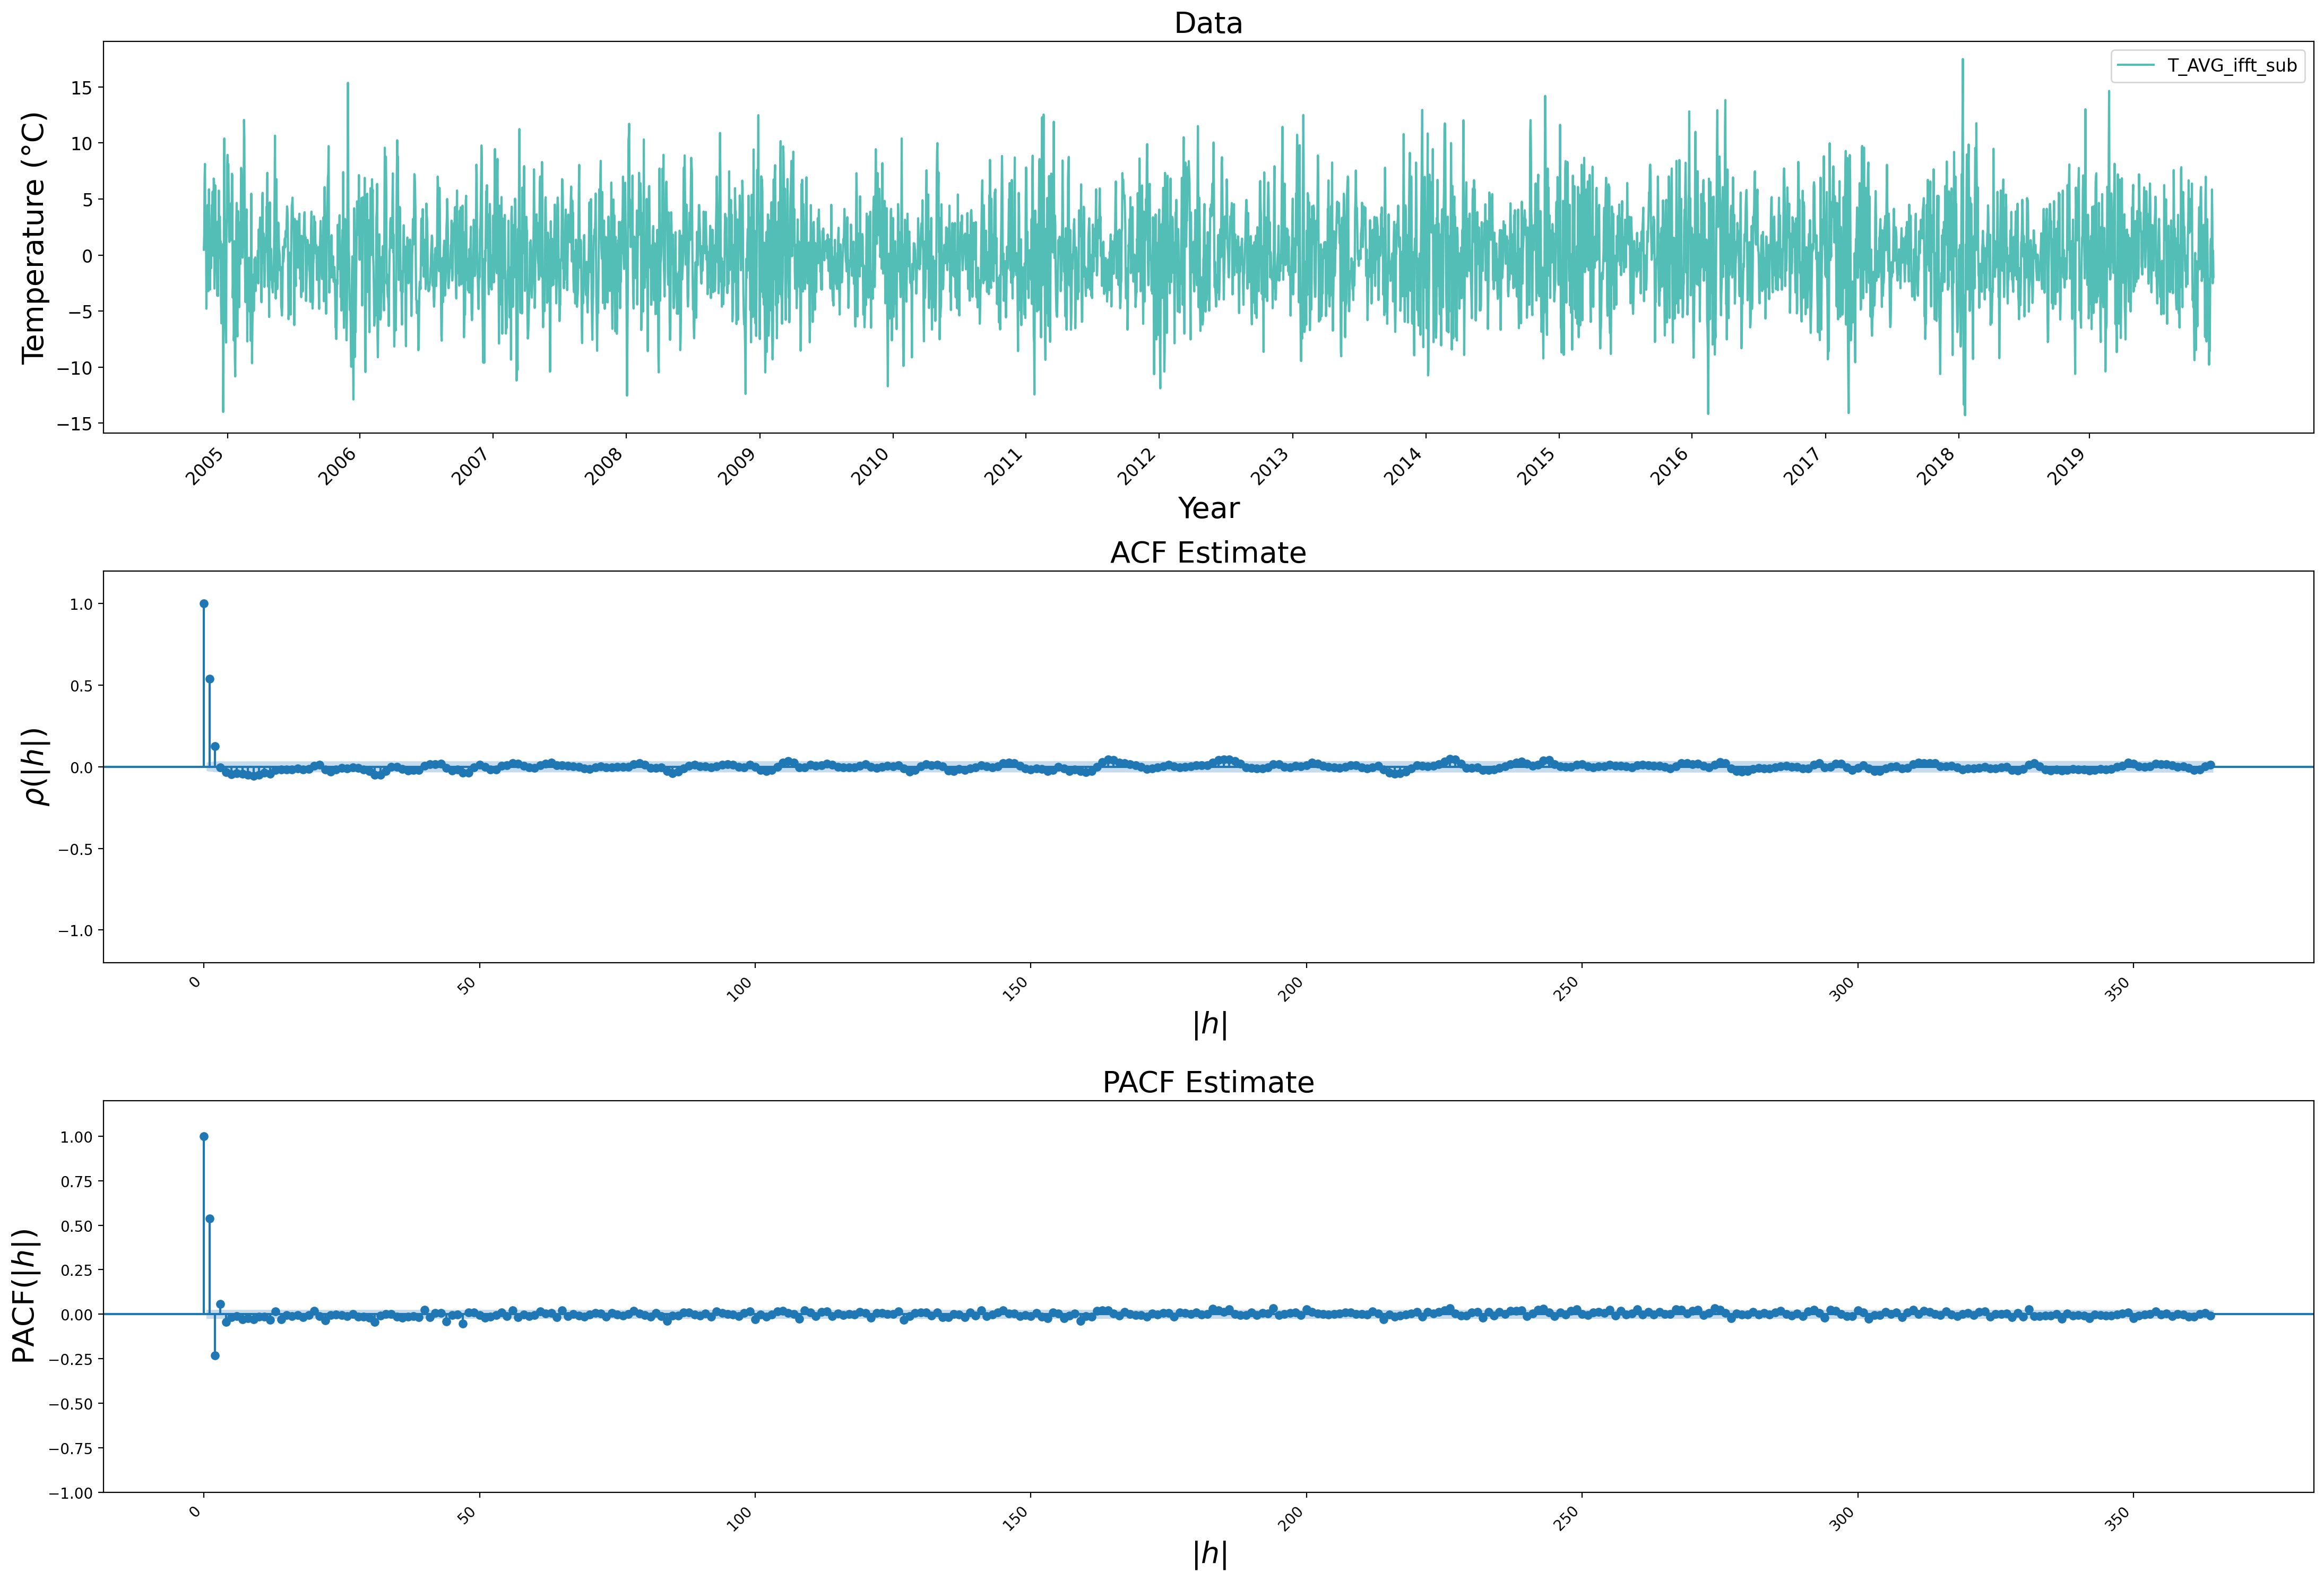

In [25]:
## triplot
seasonality = 365
plot_triple_built_in(df = Ithaca_daily_train,
                     n_lags_ar = seasonality, n_lags_ma = seasonality,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_AVG_ifft_sub',fig_name = 'daily_nonseasonal_p_q_ifft')

##### 3.3.2 Trig

In [33]:
## subtract seasonality, adf test
Ithaca_daily_train['T_AVG_trig_sub'] = Ithaca_daily_train.T_AVG - trig_season(Ithaca_daily_train.index, params[0], params[1], params[2])
Ithaca_daily_val['T_AVG_trig_sub'] = Ithaca_daily_val.T_AVG - trig_season(Ithaca_daily_val.index, params[0], params[1], params[2])

# adf test
adfuller(Ithaca_daily_train.T_AVG_trig_sub)

(-11.489487324060406,
 4.774907018333875e-21,
 19,
 5490,
 {'1%': -3.4315416867385533,
  '5%': -2.862066607021651,
  '10%': -2.5670503117773333},
 28966.629742872065)

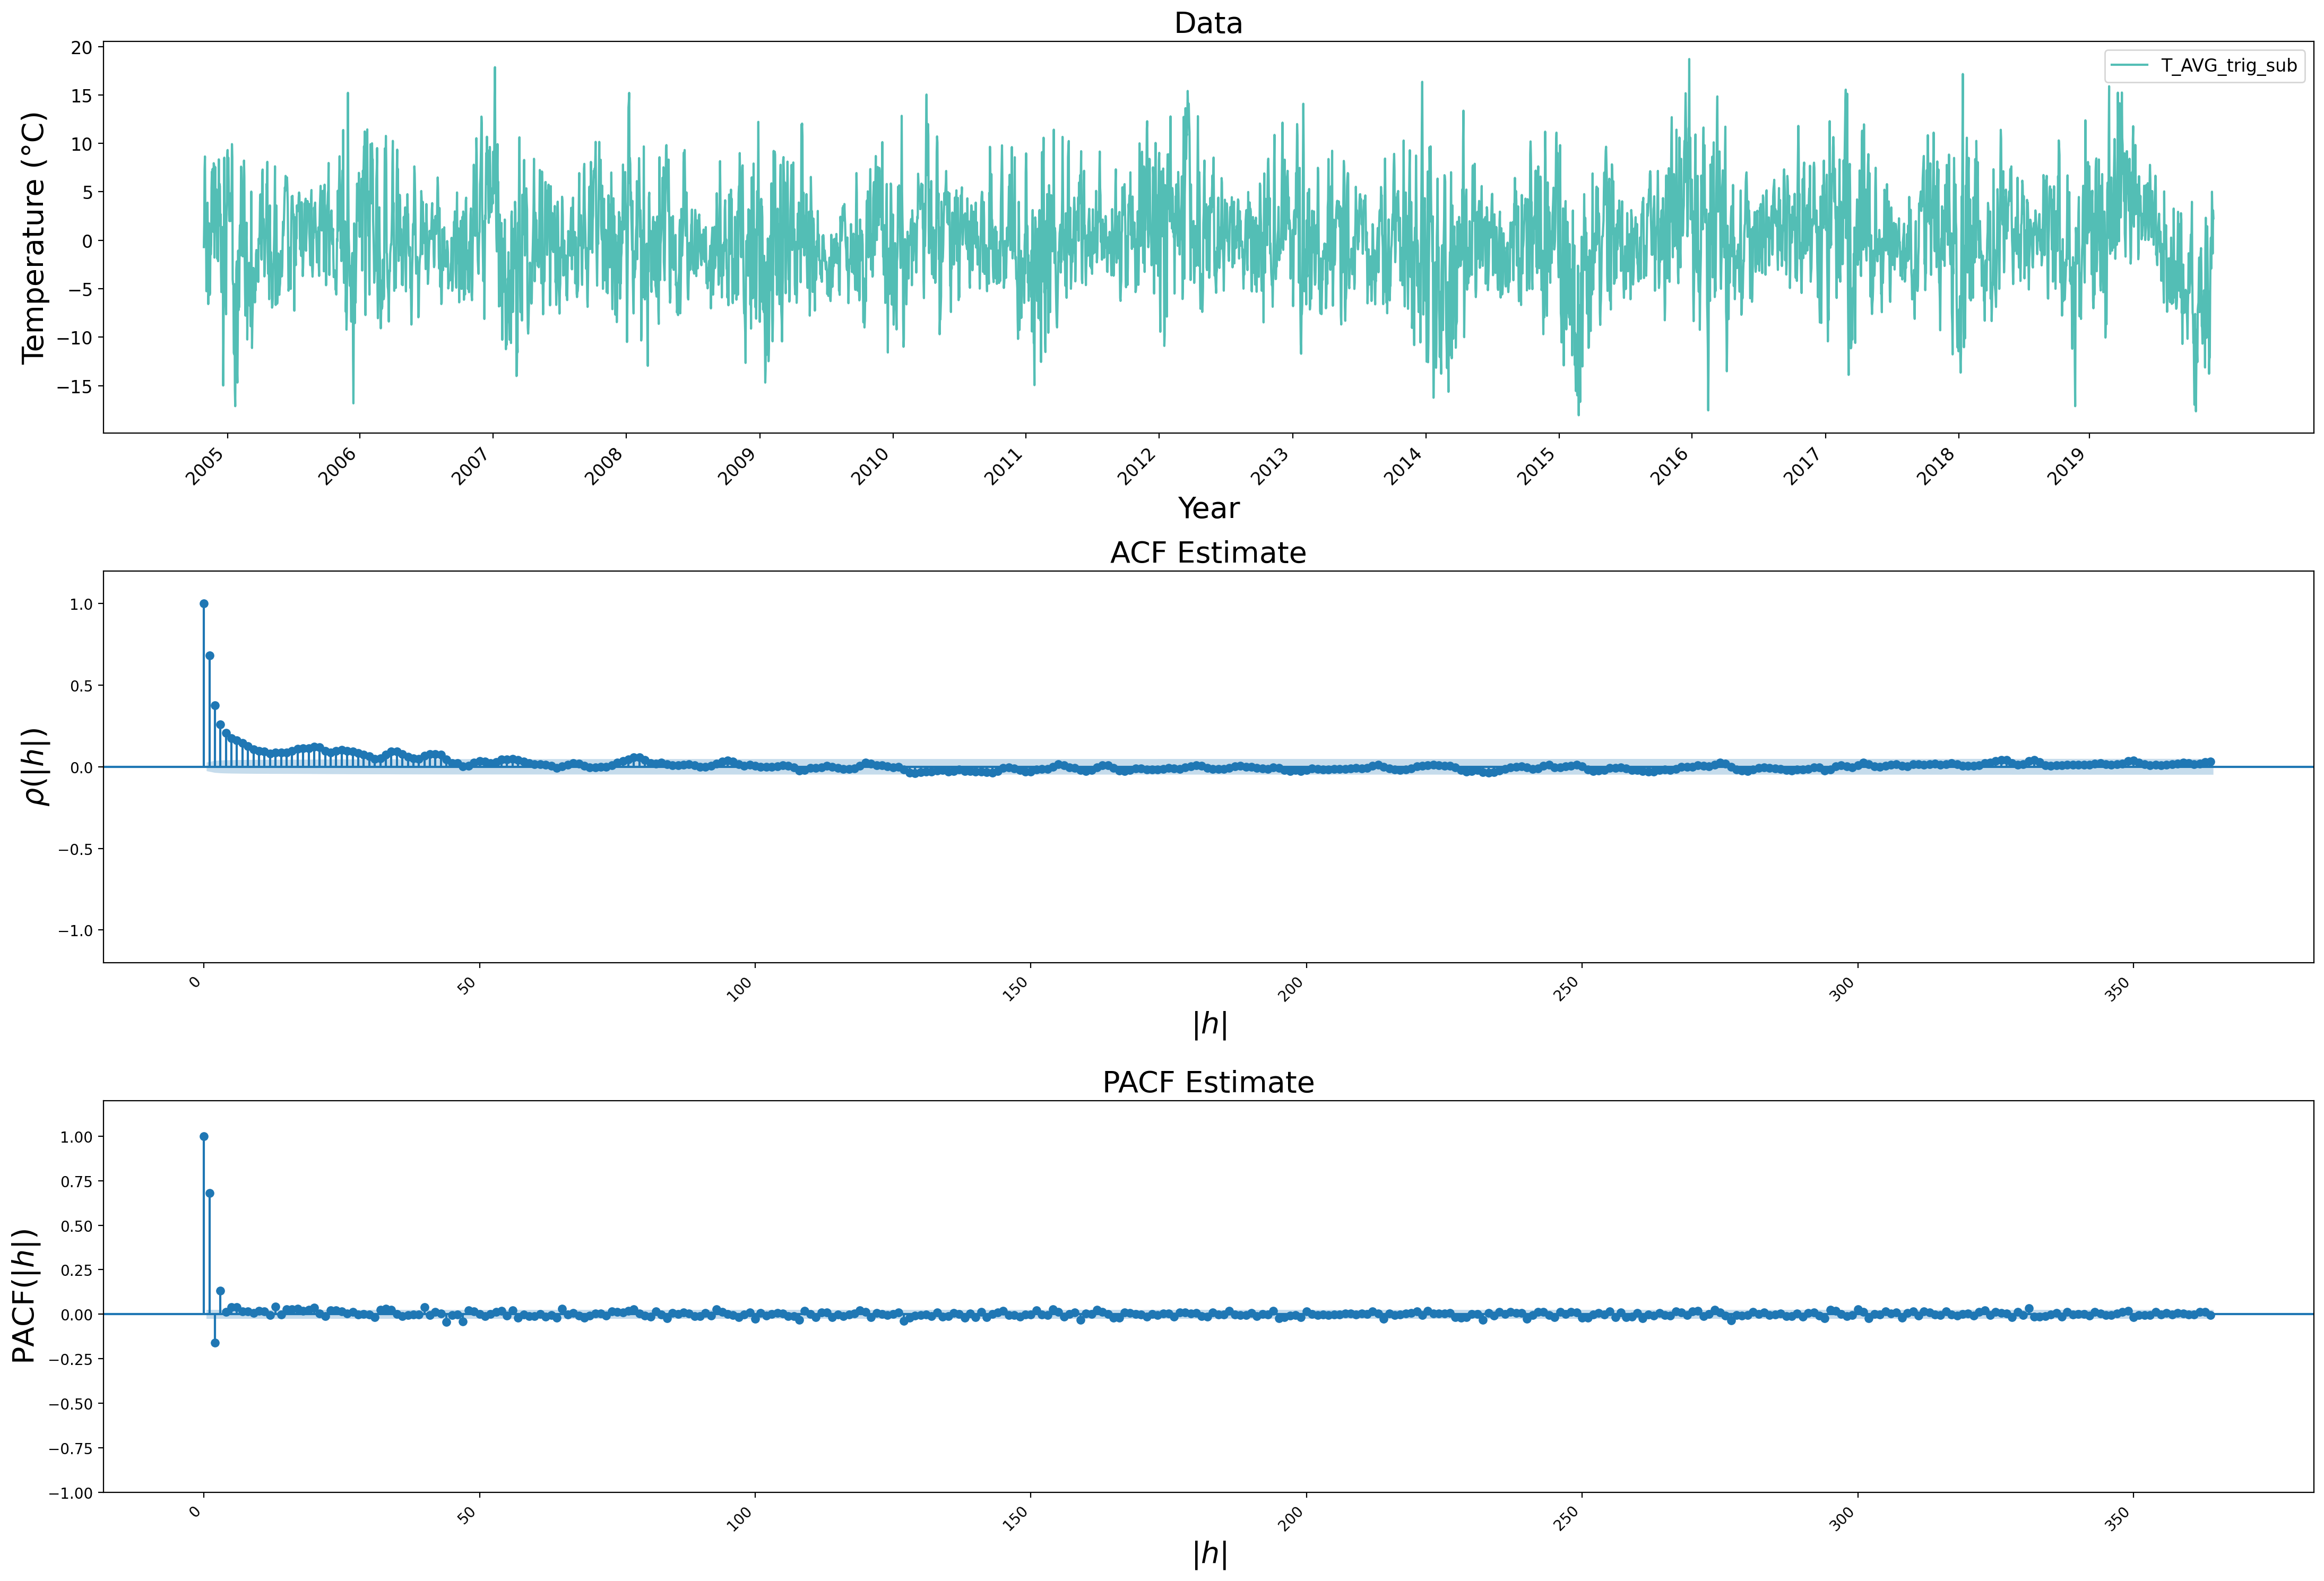

In [34]:
## triplot
seasonality = 365
plot_triple_built_in(df = Ithaca_daily_train,
                     n_lags_ar = seasonality, n_lags_ma = seasonality,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_AVG_trig_sub',fig_name = 'daily_nonseasonal_p_q')

# Don't think it is better than simply subtract T-365, etc.
# If we are dropping seasonal P, Q due to computational cost, what's the use of simple trig transform?

##### 3.3.3 subtract $X_{T-365}$

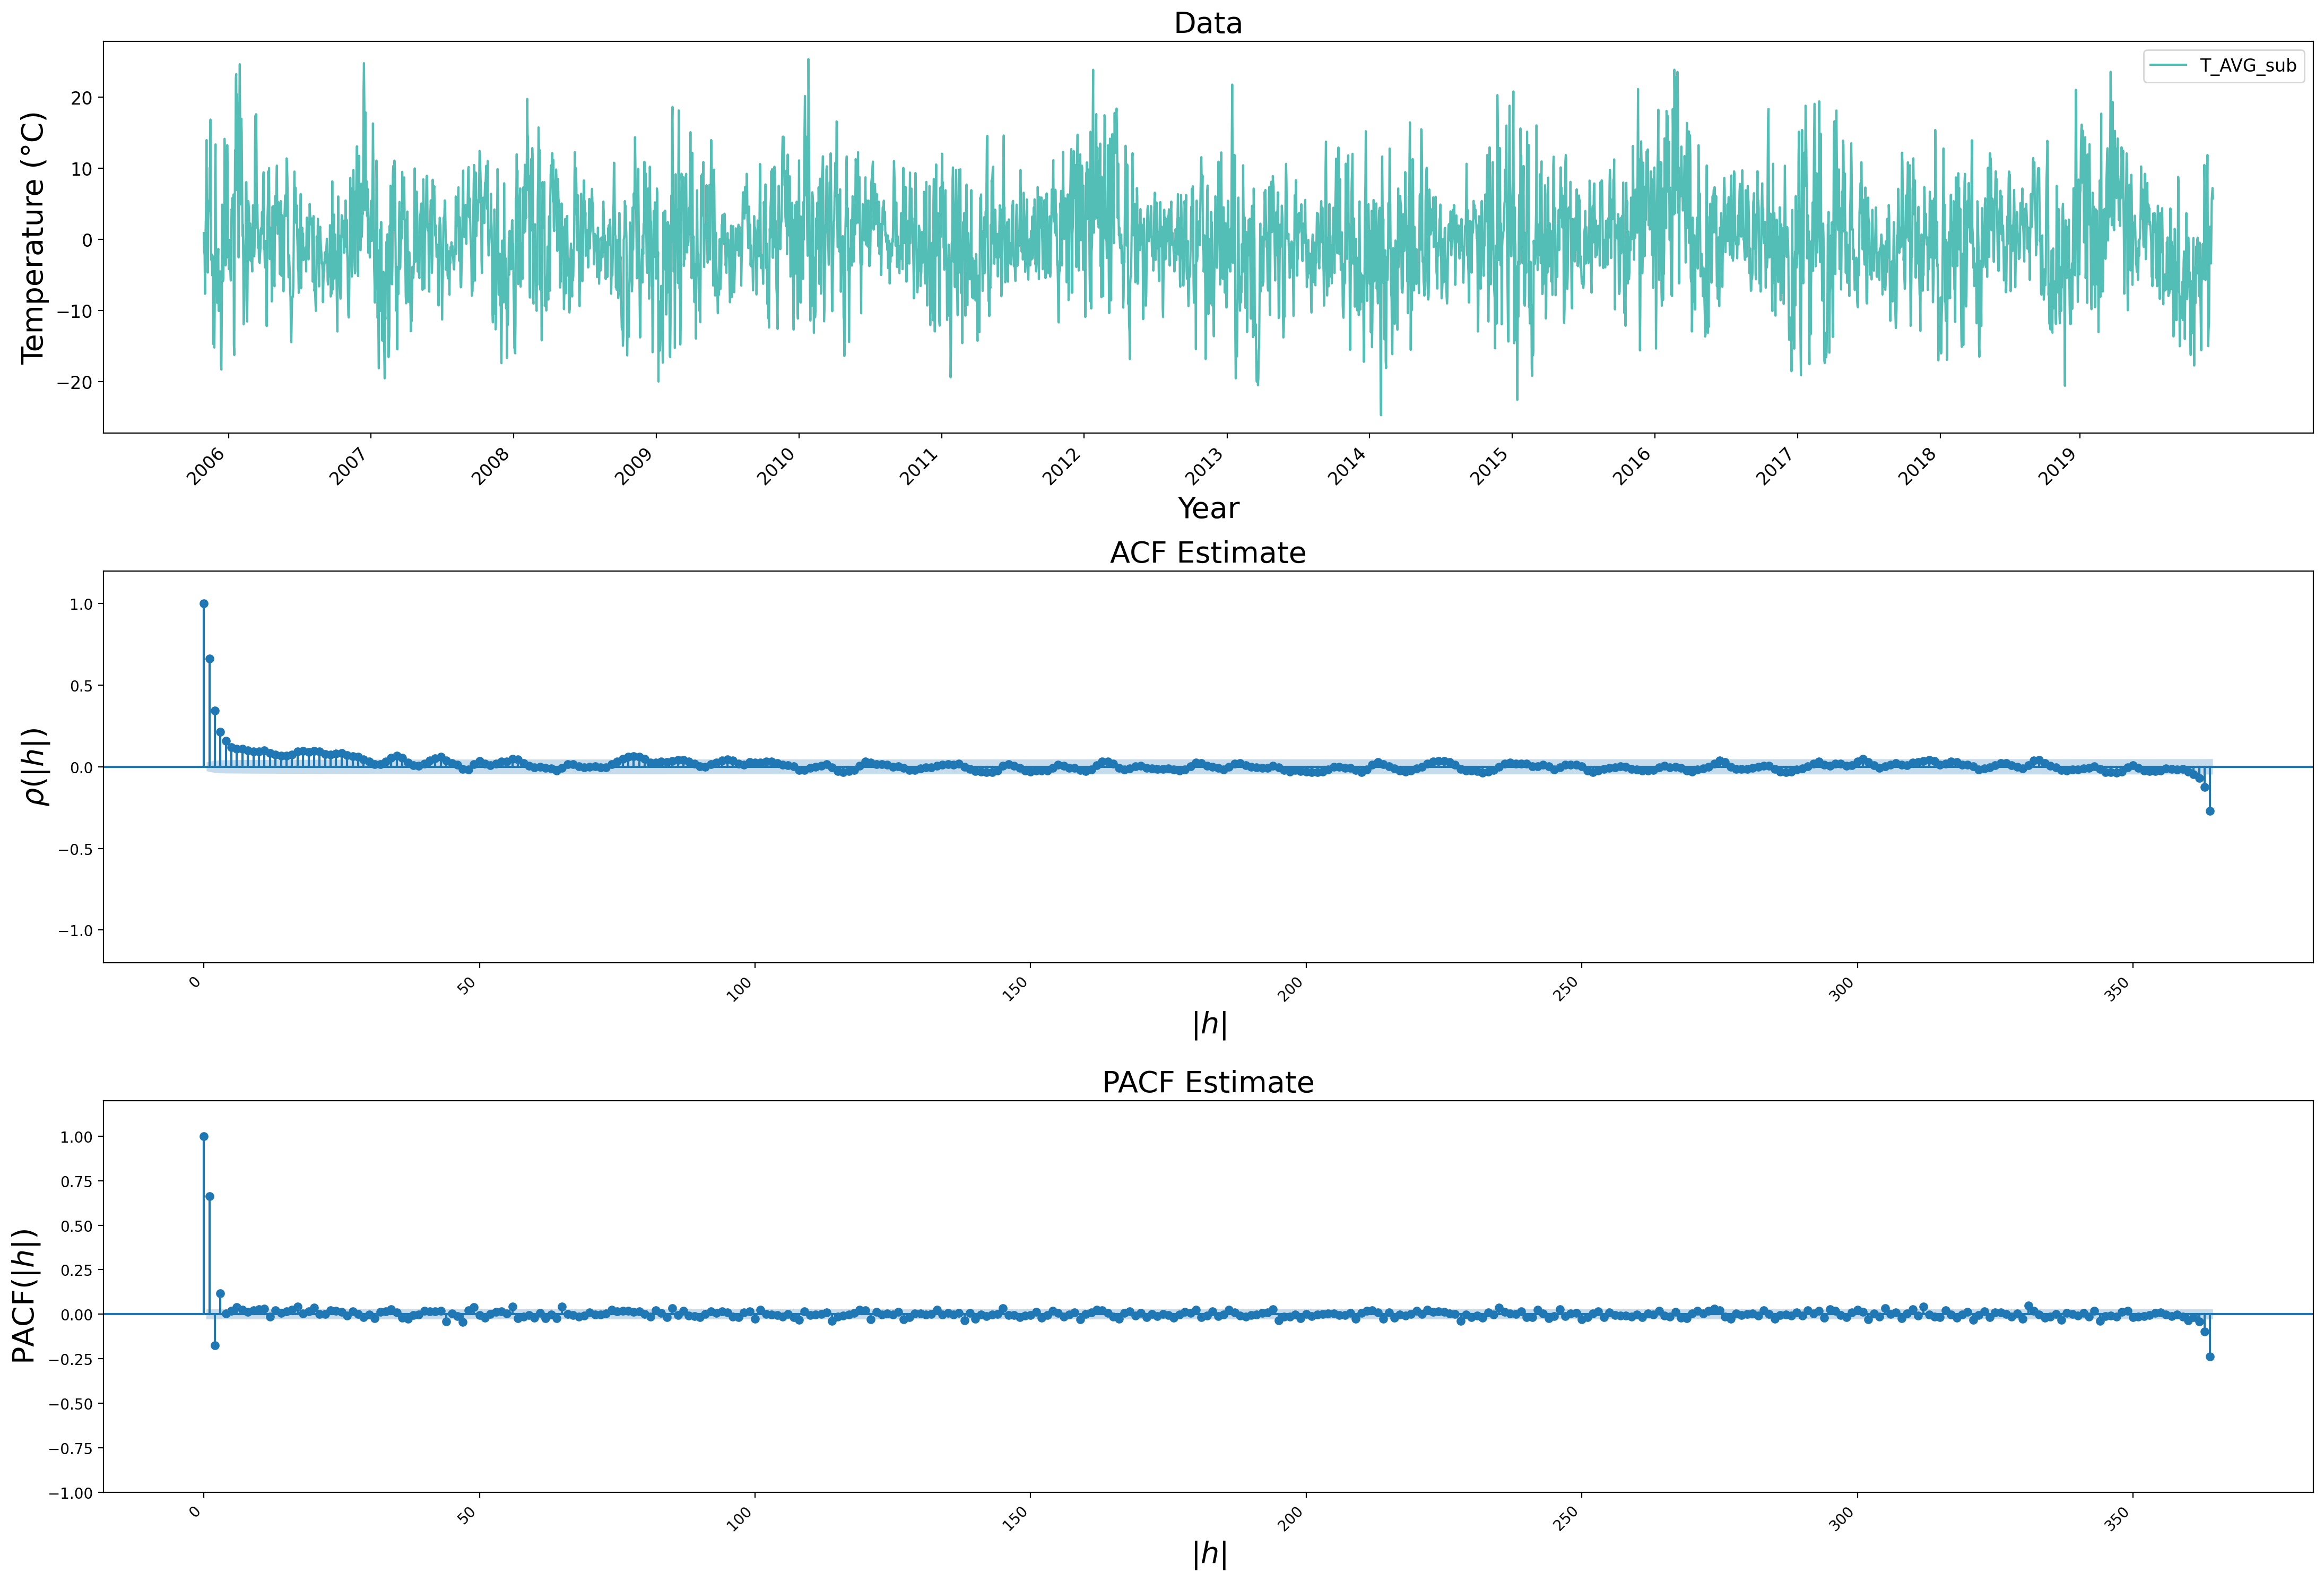

In [35]:
## triplot
seasonality = 365
plot_triple_built_in(df = Ithaca_daily_train_no_season,
                     n_lags_ar = seasonality, n_lags_ma = seasonality,
                     seasonality = 1, lag_ma = 1,
                     col = 'T_AVG_sub',fig_name = 'daily_nonseasonal_p_q_subtract')

##### 3.4 model search

In [26]:
p, q, d = range(0,4), range(0,4), range(0,1)
config_list = list(itertools.product(p, d, q))
scores = grid_search(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_ifft_sub',
                     n_val = len(Ithaca_daily_val), cfg_list = config_list, parallel = False)


100%|██████████| 1399/1399 [01:23<00:00, 16.72it/s]


 > Model[(0, 0, 0)] 2.7288


100%|██████████| 1399/1399 [03:34<00:00,  6.53it/s]


 > Model[(0, 0, 1)] 2.6269


100%|██████████| 1399/1399 [04:36<00:00,  5.06it/s]


 > Model[(0, 0, 2)] 2.6761


100%|██████████| 1399/1399 [08:00<00:00,  2.91it/s]


 > Model[(0, 0, 3)] 2.6773


100%|██████████| 1399/1399 [01:16<00:00, 18.38it/s]


 > Model[(1, 0, 0)] 2.6887


100%|██████████| 1399/1399 [04:01<00:00,  5.80it/s]


 > Model[(1, 0, 1)] 2.6756


100%|██████████| 1399/1399 [09:39<00:00,  2.42it/s]


 > Model[(1, 0, 2)] 2.6776


100%|██████████| 1399/1399 [17:03<00:00,  1.37it/s]


 > Model[(1, 0, 3)] 2.6631


100%|██████████| 1399/1399 [01:31<00:00, 15.21it/s]


 > Model[(2, 0, 0)] 2.6757


100%|██████████| 1399/1399 [07:13<00:00,  3.23it/s]


 > Model[(2, 0, 1)] 2.6768


100%|██████████| 1399/1399 [19:09<00:00,  1.22it/s]


 > Model[(2, 0, 2)] 2.6649


100%|██████████| 1399/1399 [32:49<00:00,  1.41s/it]


 > Model[(2, 0, 3)] 2.6658


100%|██████████| 1399/1399 [01:52<00:00, 12.47it/s]


 > Model[(3, 0, 0)] 2.6768


100%|██████████| 1399/1399 [10:26<00:00,  2.23it/s]


 > Model[(3, 0, 1)] 2.6764


100%|██████████| 1399/1399 [31:23<00:00,  1.35s/it]


 > Model[(3, 0, 2)] 2.6655


100%|██████████| 1399/1399 [53:06<00:00,  2.28s/it]

 > Model[(3, 0, 3)] 2.6677


In [ ]:
## ifft
## > Model[(0, 0, 0)] 2.7288
## > Model[(0, 0, 1)] 2.6269 (best)
## > Model[(0, 0, 2)] 2.6761
## > Model[(0, 0, 3)] 2.6773
## > Model[(1, 0, 0)] 2.6887
## > Model[(1, 0, 1)] 2.6756
## > Model[(1, 0, 2)] 2.6776
## > Model[(1, 0, 3)] 3.0002
## > Model[(2, 0, 1)] 2.6768
## > Model[(2, 0, 1)] 2.6768
## > Model[(2, 0, 2)] 2.6649
## > Model[(2, 0, 3)] 2.6658
## > Model[(3, 0, 0)] 2.6768
## > Model[(3, 0, 1)] 2.6764
## > Model[(3, 0, 2)] 2.6655
## > Model[(3, 0, 3)] 2.6677


### simple trig
## > Model[(0, 0, 1)] 4.5253
## > Model[(0, 0, 2)] 4.0678
## > Model[(0, 0, 3)] 3.9000
## > Model[(1, 0, 0)] 3.6928
## > Model[(1, 0, 1)] 3.7203
## > Model[(1, 0, 2)] 3.5966
## > Model[(1, 0, 3)] 3.4710
## > Model[(2, 0, 0)] 3.7281
## > Model[(2, 0, 1)] 3.6881
## > Model[(2, 0, 2)] 3.4423 (best)
## > Model[(2, 0, 3)] 3.4434
## > Model[(3, 0, 0)] 3.6195
## > Model[(3, 0, 1)] 3.4625
## > Model[(3, 0, 2)] 3.4430
## > Model[(3, 0, 3)] 3.4429
## > Model[(2, 0, 4)] 3.4446
## > Model[(2, 0, 6)] 3.4492
## > Model[(2, 0, 8)] 3.4478


### subtraction: poor model
## > Model[(0, 0, 0)] 6.2337
#  > Model[(0, 0, 1)] 5.0050
#  > Model[(0, 0, 2)] 4.8542
#  > Model[(0, 0, 3)] 4.8362
#  > Model[(1, 0, 1)] 4.8293
#  > Model[(1, 0, 3)] 4.8160
#  > Model[(2, 0, 1)] 4.8294

##### 3.5 Model Fitting

##### 3.5.1 FFT

- top 50

In [42]:
cfg = (0, 0, 1)
# key, res = score_model(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_ifft_sub',
#                        n_val = len(Ithaca_daily_val), cfg = cfg, debug=False, save = True)

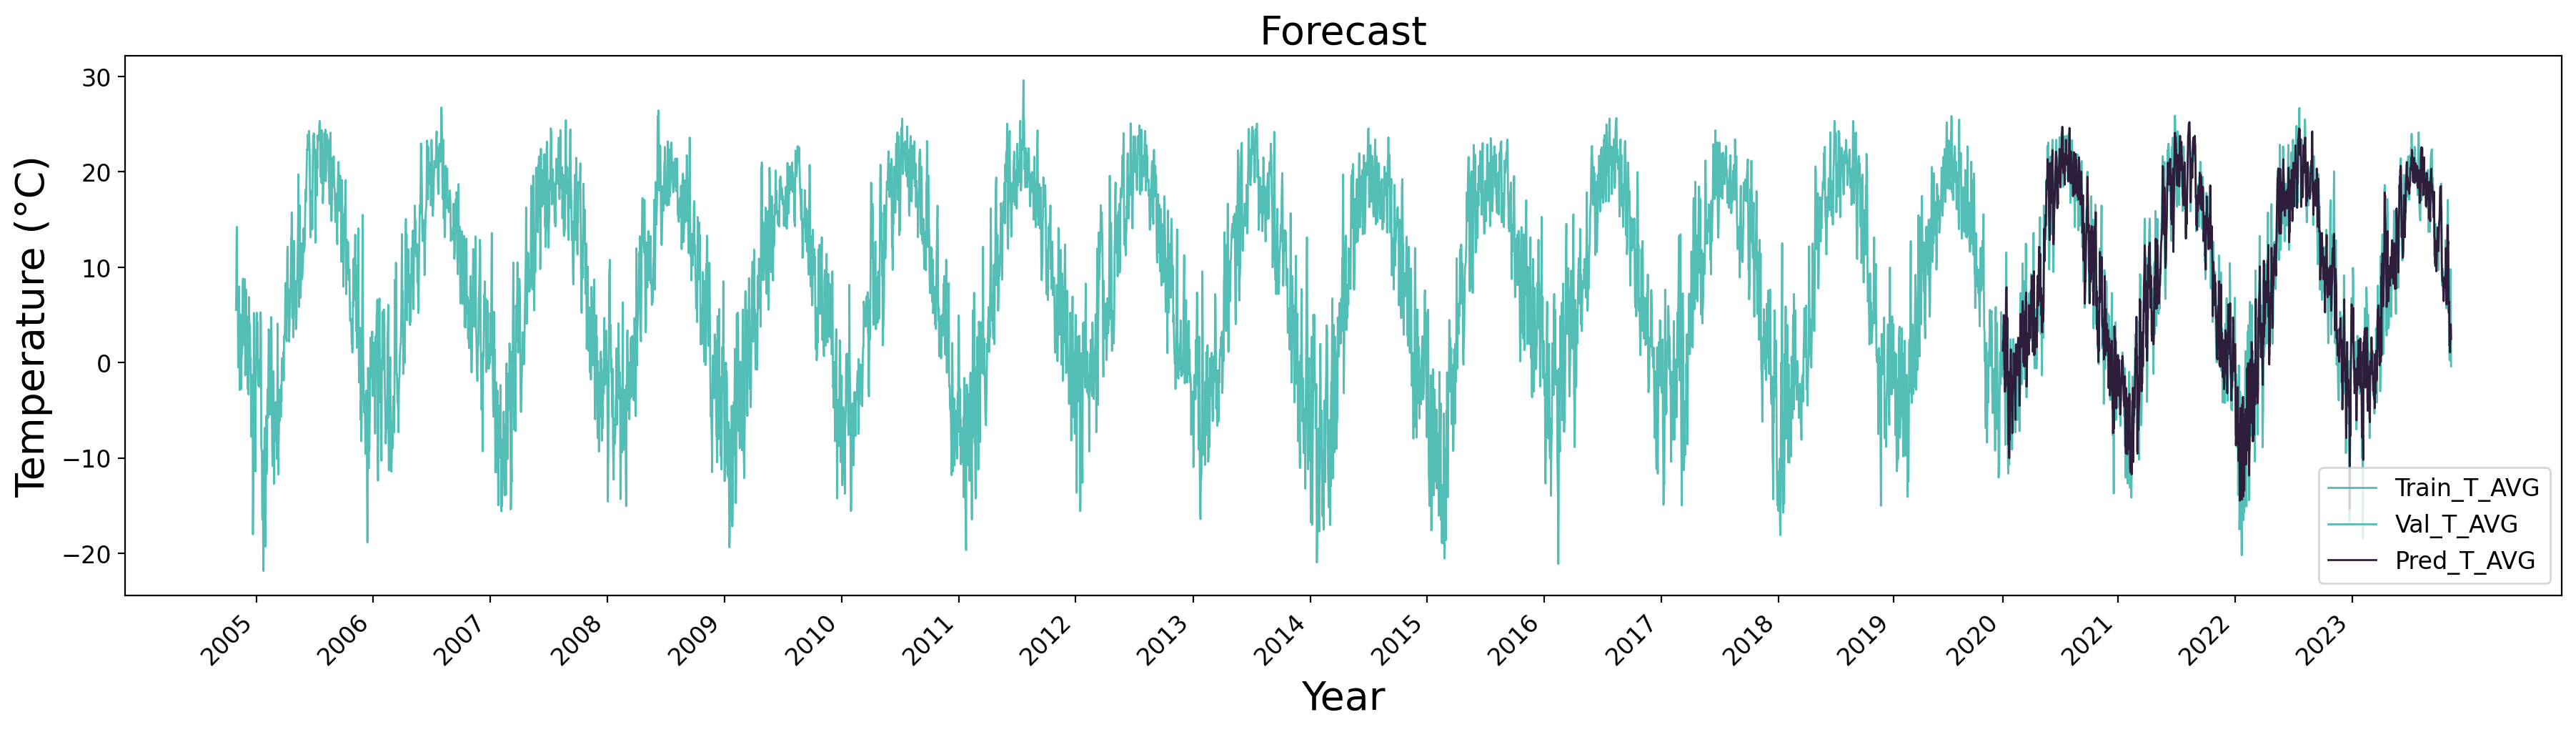

In [43]:
preds = np.load(f'{os.getcwd()}/arma_{cfg}_predictions.npy')
preds_add_season = preds + Ithaca_daily_val_recon
preds_add_season = np.array(preds_add_season).reshape(-1,1)

plot_forecast(Ithaca_daily_train, Ithaca_daily_val, preds_add_season, 
              n_from_train_end = len(Ithaca_daily_train), n_from_val_start = len(Ithaca_daily_val),
             col = 'T_AVG', pred_col = 'T_AVG', save = True, label = 'ifft_50')

- top 100

In [28]:
# 100 top a_n**2 + b_n**2
label = '_100'
key, res = score_model(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_ifft_sub',
                       n_val = len(Ithaca_daily_val), cfg = cfg, debug=False, save = True, label = label)
## > Model[(0, 0, 1)] 2.6496

100%|██████████| 1399/1399 [03:29<00:00,  6.68it/s]

 > Model[(0, 0, 1)] 2.6269


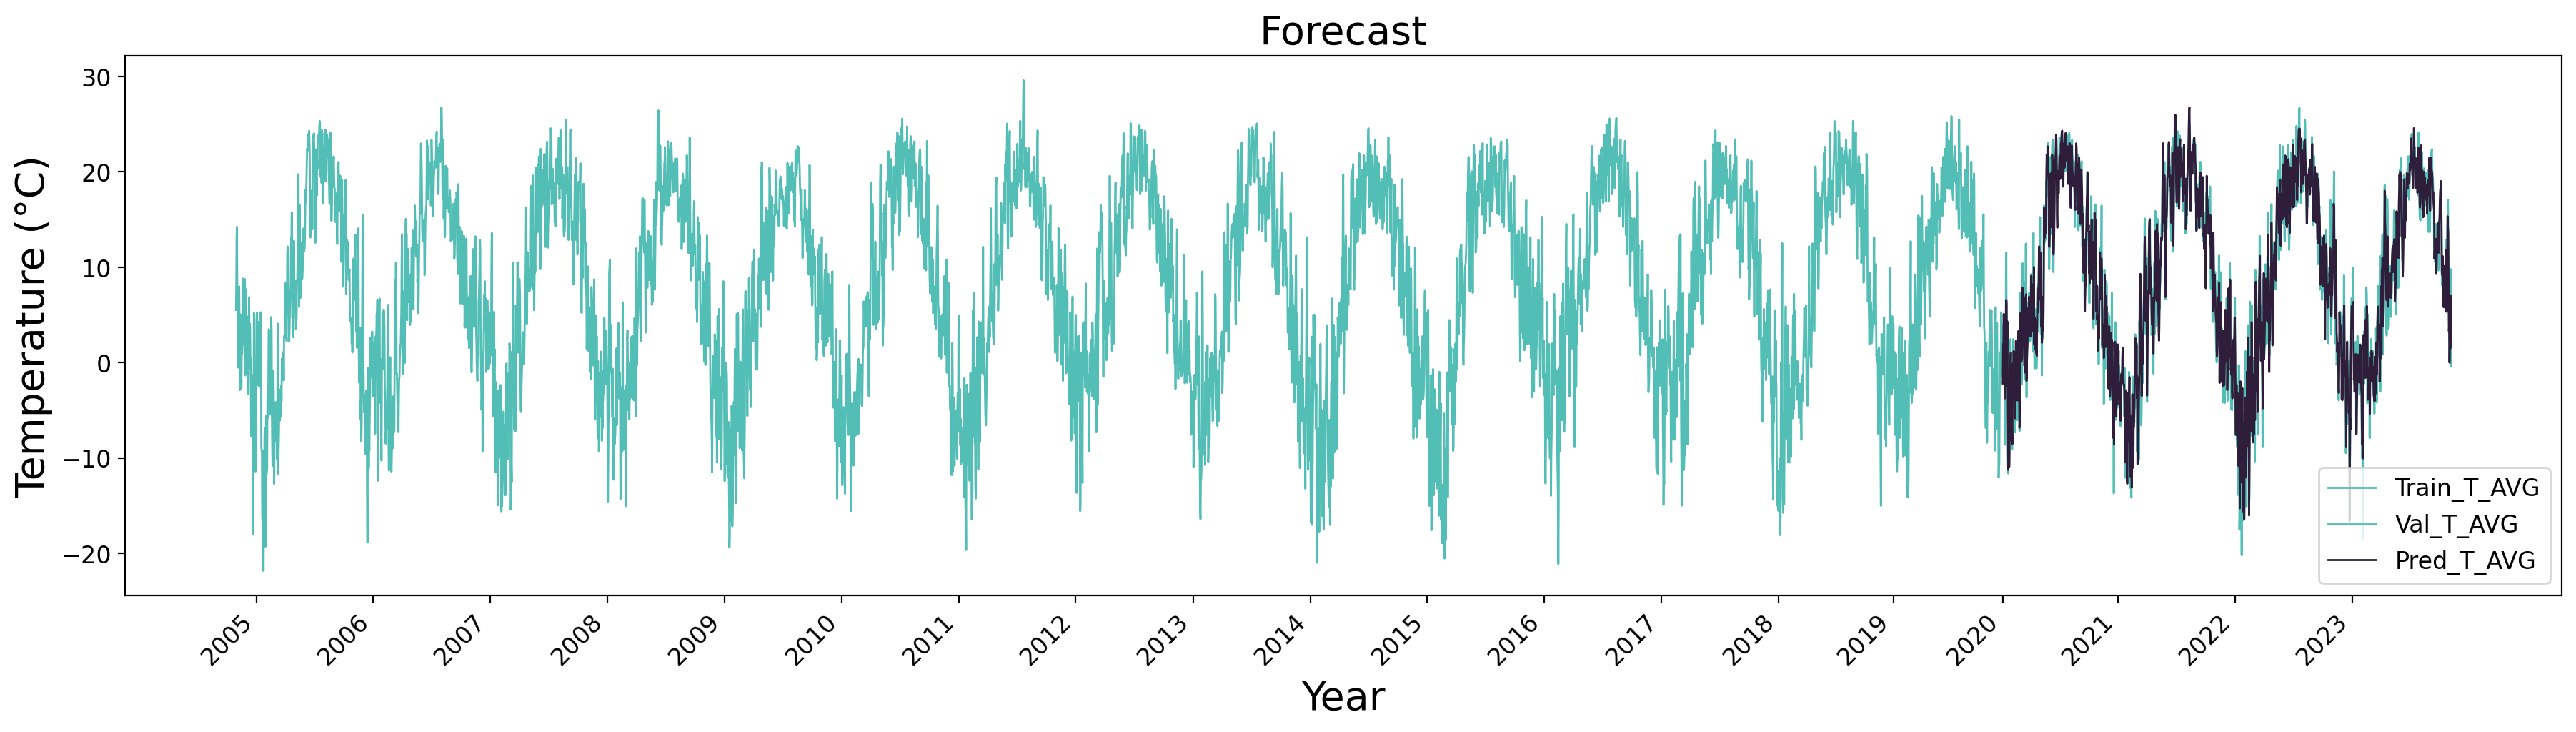

In [52]:
label = '_100'
preds = np.load(f'{os.getcwd()}/arma_{cfg}_predictions{label}.npy')
preds_add_season = preds + Ithaca_daily_val_recon
preds_add_season = np.array(preds_add_season).reshape(-1,1)

plot_forecast(Ithaca_daily_train, Ithaca_daily_val, preds_add_season, 
              n_from_train_end = len(Ithaca_daily_train), n_from_val_start = len(Ithaca_daily_val),
             col = 'T_AVG', pred_col = 'T_AVG', save = True, label = 'ifft_100')

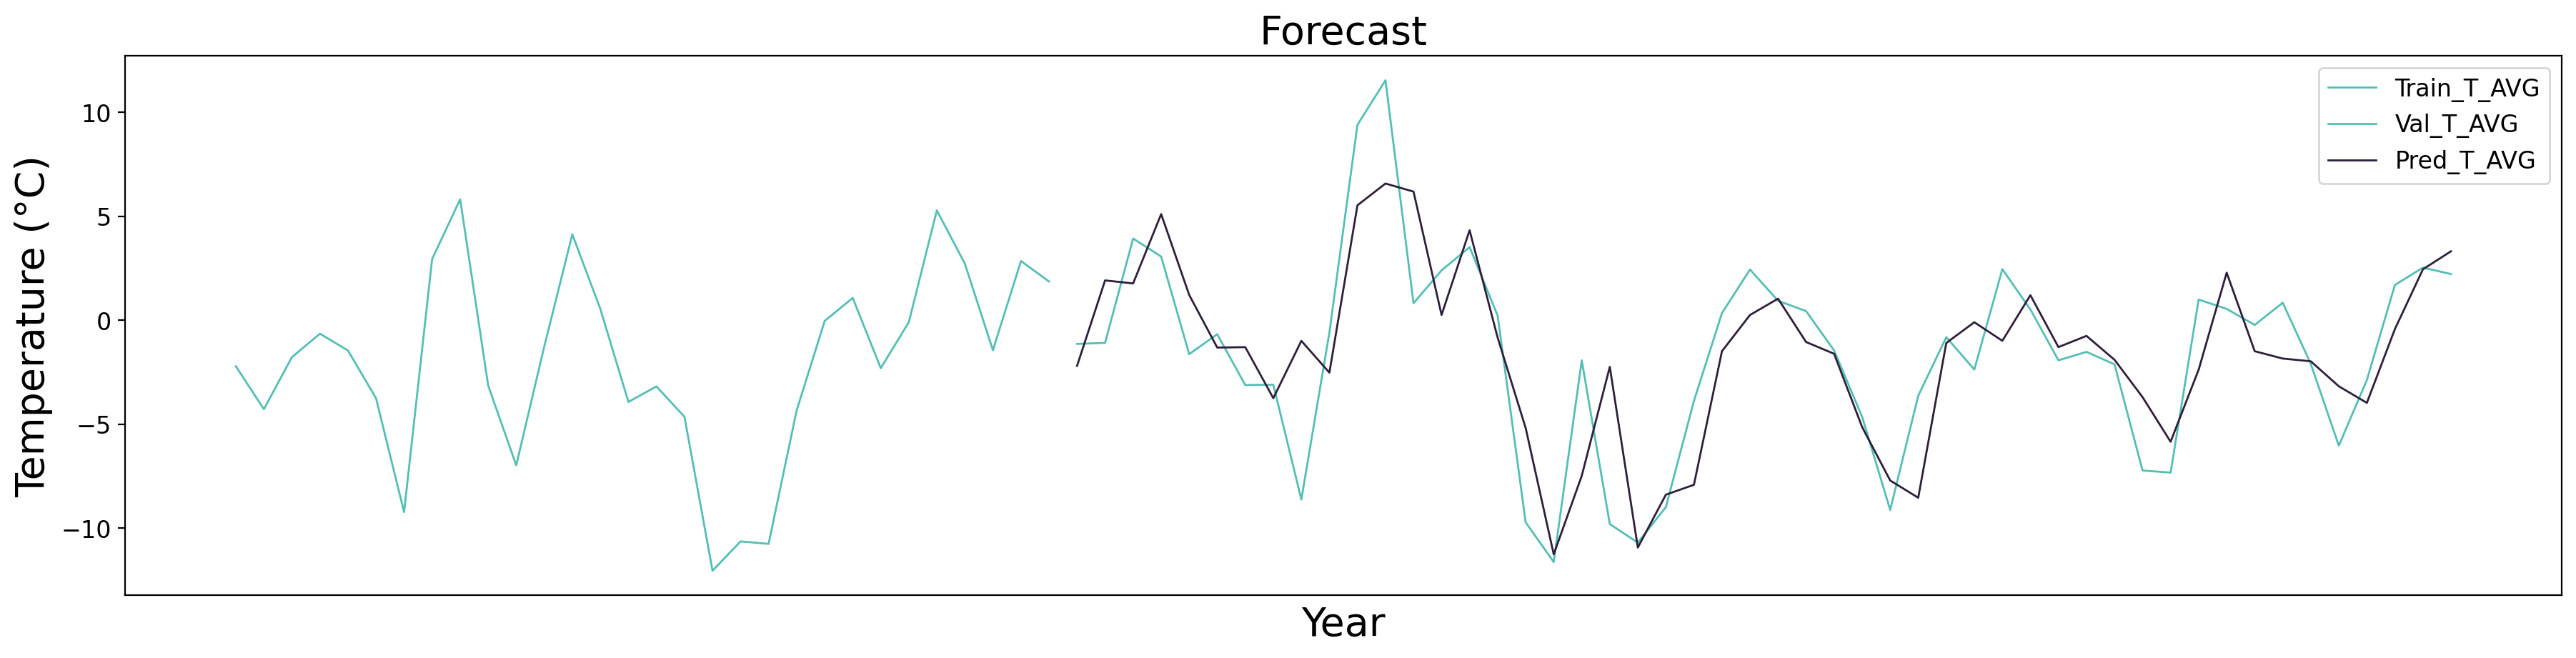

In [89]:
label = '_100'
preds = np.load(f'{os.getcwd()}/arma_{cfg}_predictions{label}.npy')
preds_add_season = preds + Ithaca_daily_val_recon
preds_add_season = np.array(preds_add_season).reshape(-1,1)

plot_forecast(Ithaca_daily_train, Ithaca_daily_val, preds_add_season, 
              n_from_train_end = 30, n_from_val_start = 50,
             col = 'T_AVG', pred_col = 'T_AVG', save = True, label = 'ifft_100')

In [55]:
## SMAPE (Symmetric Mean Absolute Percentage Error)
## ref: https://medium.com/@vinitkothari.24/time-series-evaluation-metrics-mape-vs-wmape-vs-smape-which-one-to-use-why-and-when-part1-32d3852b4779
## lower -> better
def SMAPE(predictions, true):
    weighted = np.abs(predictions - true)/(np.abs(predictions) + np.abs(true))
    scalar = 100/len(true)
    return scalar * weighted.sum()
    
val_T_AVG_no_season = Ithaca_daily_val.T_AVG_ifft_sub.values.reshape(-1,1)

print('-'*20 + 'not including seasonality' + '-'*20 + '\n')
print(f'SMAPE for arma_{cfg}_predictions{label} = {SMAPE(preds, val_T_AVG_no_season)}\n\n') 
# looks unstable for small values
print('-'*20 + 'including seasonality' + '-'*20 + '\n')
preds_ = preds_add_season
vals_ = Ithaca_daily_val.T_AVG.values.reshape(-1,1)
SMAPE_ = np.sum(np.abs(preds_ - vals_))/np.sum(vals_)
print(f'SMAPE for arma_{cfg}_predictions{label} = {SMAPE(preds_, vals_)}\n\n')
# so fft helps a lot

--------------------not including seasonality--------------------

SMAPE for arma_(0, 0, 1)_predictions_100 = 104414.60143932202


--------------------including seasonality--------------------

SMAPE for arma_(0, 0, 1)_predictions_100 = 21.504953236019077




##### 3.5.2 trig

In [36]:
## currently, within the limited search space, I find (p,d,q) = (2,0,2) return the best walk-forward validation rmse.
## Since I only include train & val set. I'll refit the model, report residuals, plot graphs.
cfg = (2, 0, 2)
# key, res = score_model(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_trig_sub',
#                        n_val = len(Ithaca_daily_val), cfg = cfg, debug=False, save = True)
# I already ran this model and stored results, so just load

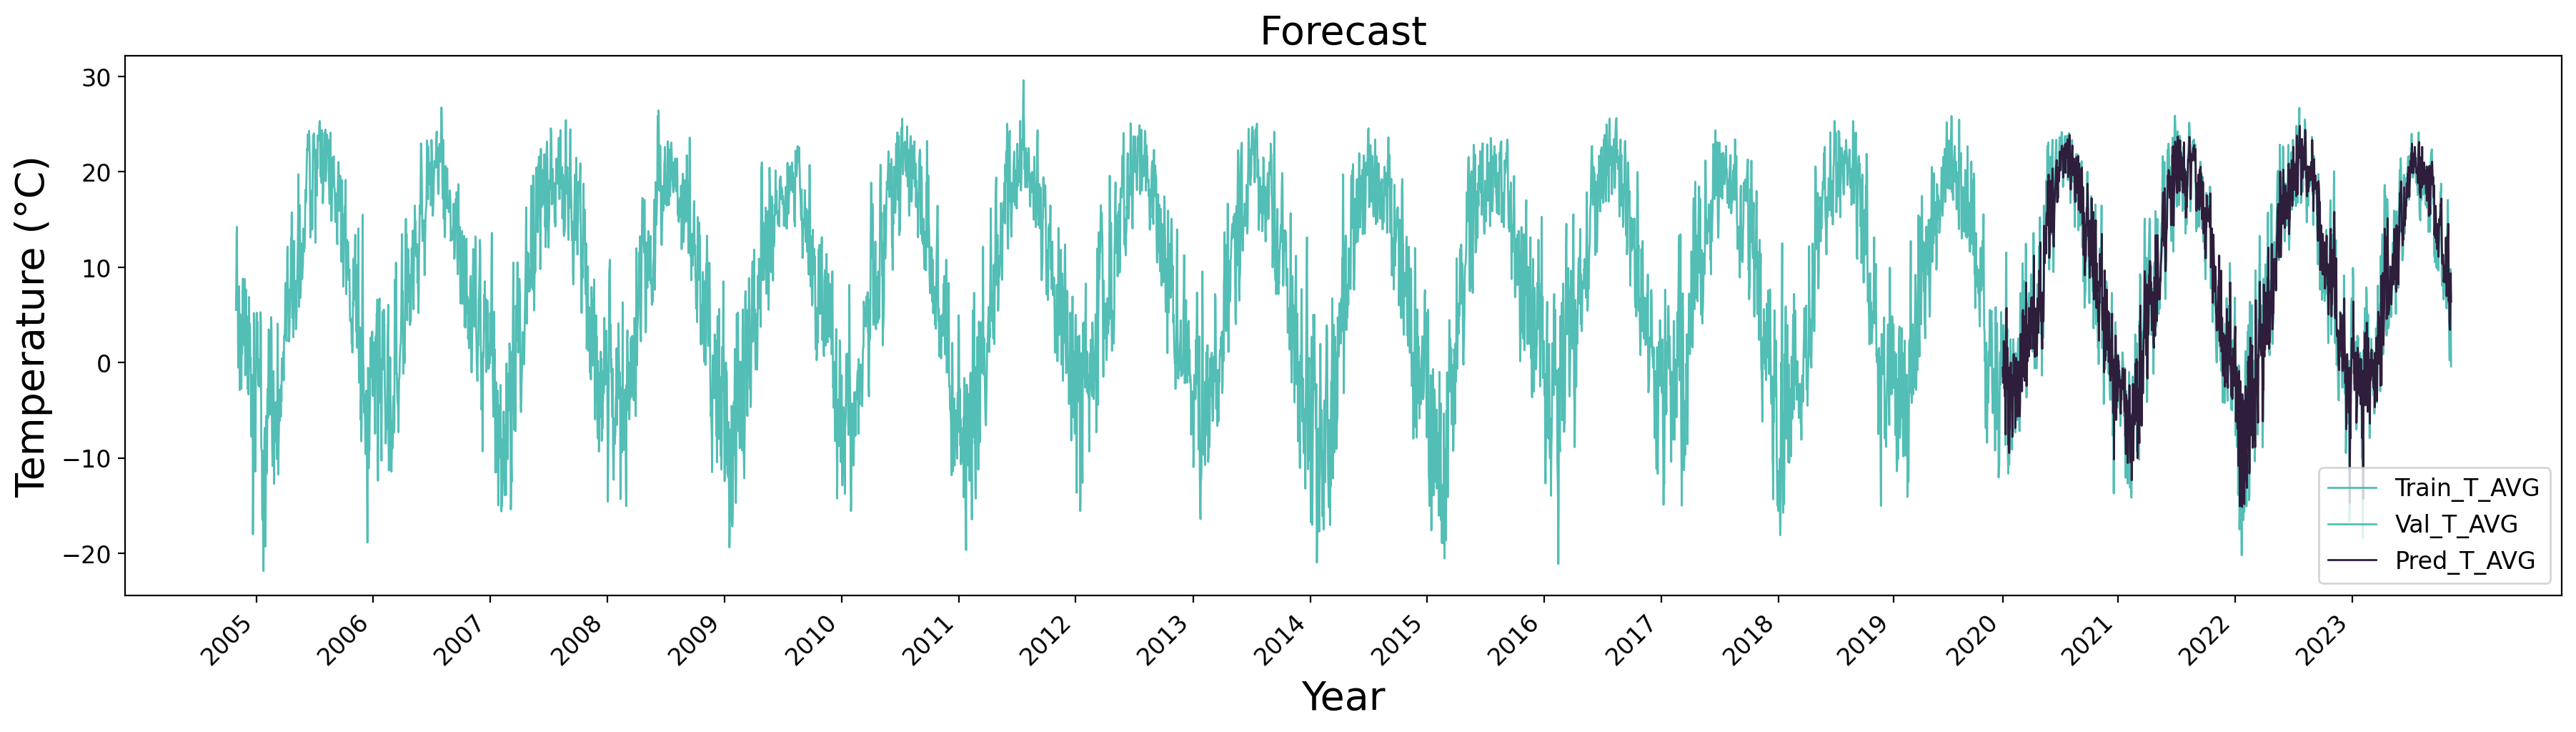

In [37]:
preds = np.load(f'arma_{cfg}_predictions.npy')
preds_add_season = preds + trig_season(Ithaca_daily_val.index, params[0], params[1], params[2])
preds_add_season = np.array(preds_add_season).reshape(-1,1)

plot_forecast(Ithaca_daily_train, Ithaca_daily_val, preds_add_season, 
              n_from_train_end = len(Ithaca_daily_train), n_from_val_start = len(Ithaca_daily_val),
             col = 'T_AVG', pred_col = 'T_AVG', save = False)

##### 3.5.3 subtract $X_{T-365}$

In [ ]:
cfg = (2, 0, 2)
key, res = score_model(Ithaca_daily_train_no_season, Ithaca_daily_val_no_season, col = 'T_AVG_sub',
                       n_val = len(Ithaca_daily_val_no_season), cfg = cfg, debug=False, save = True, label = '_sub_365')

# 4.8173. Do not use.

##### 3.6 Residual Plot

In [111]:
## TODO

### Random Trial

In [ ]:
## Let's aggregate by month
nyc_monthly = nyc_daily_drop.groupby(['year','month']).mean()
nyc_monthly.reset_index(inplace = True)

fontsize = 12
fig_overall, ax = plt.subplots(1,1, figsize = (12,4))
sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMAX'],
              color = palette[1], label = 'TMAX', alpha = 0.9)
# sns.lineplot(x = nyc_monthly.index, y = nyc_monthly['TMIN'],
#               color = palette[-1], label = 'TMIN', alpha = 0.9)
ax.set_xticklabels([])
ax.set_xticks([])
ax.tick_params(axis = 'y', labelsize = 10)
ax.set_ylabel('Temperature (°F)', fontsize = fontsize)
ax.set_xlabel('Date', fontsize = fontsize)
ax.legend(fontsize = 12)
plt.show()

In [ ]:
nyc_monthly.index

In [ ]:
## cp output to drive
!scp *.png drive/MyDrive/Colab\ Notebooks/

##### Failed auto_arima

In [ ]:
## Does not work. running for 47 mins without result
## search for the best model
# Or maybe just use auto_arima
# P <= 3, Q <= 1; p <= 3, q <= 27

res = pm.auto_arima(Ithaca_daily_train.T_AVG, d = 0,
                    start_p = 1,
                    start_q = 1,
                    max_p = 3,
                    max_q = 5,
                    seasonal = True,
                    m = 365,
                    D = 1,
                    start_P = 1,
                    start_Q = 1,
                    max_P = 3,
                    max_Q = 1,
                    information_criterion='aic')

##### Failed SARIMAX

In [ ]:
## search for the best model
# P <= 3, Q <= 1; p <= 3, q <= 27 -> impossible to solve for such a range. so truncate.
# Note large q won't work. Computationally expensive.
P, Q, p, q, D, s, d = range(0,4), range(1,2), range(1,4), range(1,4), range(1,2), range(365,366), range(0,1)
config_list = list(itertools.product(p, d, q, P, D, Q, s))
scores = grid_search(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG',
                     n_val = len(Ithaca_daily_val), cfg_list = config_list, parallel = False)

In [ ]:
sarima_forecast(history = list(Ithaca_daily_train['T_AVG']), config = config_list[0]) # it is not feasible... too slow...
# Let's just try Fourier Transform first, then ARMA

In [ ]:
walk_forward_validation(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_trig_sub',
                        n_val = len(Ithaca_daily_val), cfg = config_list[1])

##### Replaced by codes from lab 10

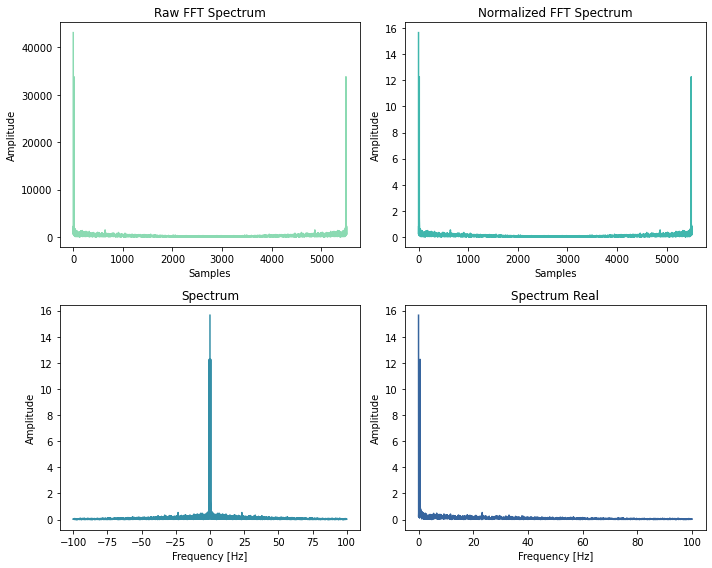

In [29]:
## take a look at fft
## https://towardsdatascience.com/fourier-transform-the-practical-python-implementation-acdd32f1b96a

signal = np.array(Ithaca_daily_train.T_AVG)
T = len(signal)
normalize = T/2
fft_result = fft(signal)
sampling_rate = 200
frequency_axis = fftfreq(T, d = 1.0/sampling_rate)
norm_amplitude = np.abs(fft_result)/normalize
freq = rfftfreq(T, d = 1/sampling_rate)

fig, ax = plt.subplots(2,2, figsize = (10,8))

# the spectrum |Xk|
ax[0,0].plot(np.abs(fft_result), color = palette[0])
ax[0,0].set_ylabel('Amplitude')
ax[0,0].set_xlabel('Samples')
ax[0,0].set_title('Raw FFT Spectrum')

# Plot the normalized FFT (|Xk|)/(N/2)
ax[0,1].plot(norm_amplitude, color = palette[1])
ax[0,1].set_ylabel('Amplitude')
ax[0,1].set_xlabel('Samples')
ax[0,1].set_title('Normalized FFT Spectrum')

# Plot frequency vs. amplitude
ax[1,0].plot(frequency_axis, norm_amplitude, color = palette[2])
ax[1,0].set_ylabel('Amplitude')
ax[1,0].set_xlabel('Frequency [Hz]')
ax[1,0].set_title('Spectrum')

# Plot only the spectrum for real-values signal data
ax[1,1].plot(freq, 2*np.abs(rfft(signal))/T, color = palette[3])
ax[1,1].set_ylabel('Amplitude')
ax[1,1].set_xlabel('Frequency [Hz]')
ax[1,1].set_title('Spectrum Real')
plt.tight_layout()


fig.savefig('fft.png', bbox_inches = 'tight')

In [39]:
## some other trials fft + abs values 
key, res = score_model(Ithaca_daily_train, Ithaca_daily_val, col = 'T_AVG_ifft_sub',
                       n_val = len(Ithaca_daily_val), cfg = cfg, debug=False, save = True, label = '_abs')

100%|██████████| 1399/1399 [03:54<00:00,  5.96it/s]

 > Model[(0, 0, 1)] 2.9683


##### Prediction
- For time's sake, only use FFT

In [103]:
## let's make real predictions
cfg = (0, 0, 1)
history = pd.concat([Ithaca_daily_train.T_AVG_ifft_sub, Ithaca_daily_val.T_AVG_ifft_sub], axis = 0)
historical_seasonality =  np.hstack([Ithaca_daily_train_recon, Ithaca_daily_val_recon])
steps = 40

model = sarimax.SARIMAX(history, order = cfg, seasonal_order= (0,0,0,0),
                              trend=None, enforce_stationarity=False,
                              enforce_invertibility=False)

final_model = model.fit(disp = False)
future = final_model.predict(start = len(history), end = len(history) + steps)


6909    13.570723
6910    13.916030
6911    12.934527
6912    13.216315
6913    15.186098
6914    17.469607
6915    18.782973
6916    19.298739
6917    19.266155
6918    17.695714
6919    14.055800
6920    10.367743
6921     9.467077
6922    11.163604
6923    12.105879
6924    10.108099
6925     6.979531
6926     5.974910
6927     7.656116
6928     9.724069
6929    10.334483
6930     9.994933
6931    10.010858
6932    10.312179
6933     9.665448
6934     7.700515
6935     5.979131
6936     6.616991
6937     9.843175
6938    13.313704
6939    14.236665
6940    11.981632
6941     8.140043
6942     4.433068
6943     1.645626
6944     0.496528
6945     1.776312
6946     4.620207
6947     6.095136
6948     4.243341
6949     0.873700
Name: predicted_mean, dtype: float64